In [1]:
from src.HestonModel import generate_heston_paths
from src.Two_parameters_functions import signatures_calculations_with_2parameters
import numpy as np
import esig
import matplotlib.pyplot as plt
import iisignature
import signatory
import torch
from tqdm.auto import tqdm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# constant Heston parameters
theta=0.15 #Long run variance θ
kappa= 2 # Mean reversion κ
v_0 = theta #  Initial variance
rho = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigma = 0.6 #Volatility of variance σ
r = 0.04

S = 100
paths = 10000
steps = 50
T = 1

In [3]:
# Get Heston prices and volatilises
prices, sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, steps, paths, return_vol=True)

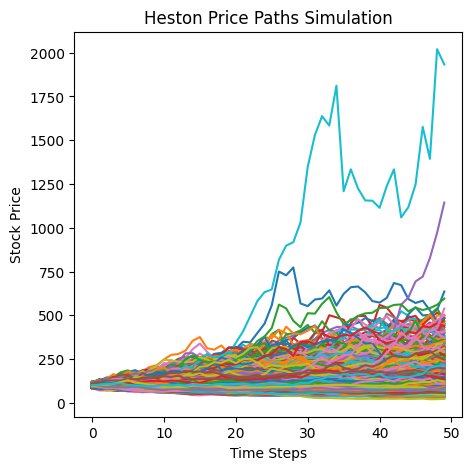

In [4]:
# Plot Heston Price paths
plt.figure(figsize=(5, 5))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()


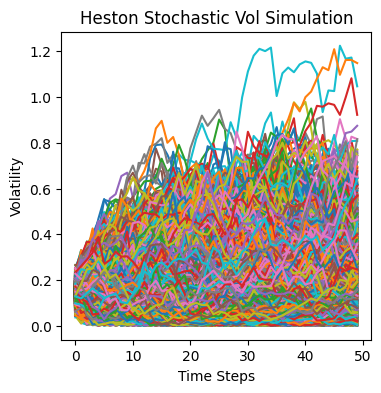

In [5]:
# Plot Heston volatility paths
plt.figure(figsize=(4, 4))
plt.plot(sigs.T)
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.show()

In [19]:
#############################################################################################

In [6]:
thetas=0.15 #Long run variance θ
kappas= 2 # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #Volatility of variance σ
rs = 0.04

S = 100
paths = 10000
steps = 50
T = 1

In [7]:
depth_of_sig=2  #level of truncation of signatures
width_of_sig=3  # prices + sigmas + time_array (parameters for signatures)
sig_keys = esig.sigkeys(width_of_sig, depth_of_sig)
sig_dim=signatory.signature_channels(width_of_sig,depth_of_sig)

In [8]:
# define time_array and empty tensor for prices and sigmas
time_array = np.arange(steps)
prices_and_sigs_with_time_tensor = torch.zeros((paths,steps, width_of_sig ))

In [9]:
by_parameter_2 = {
    "by_rs": np.linspace(0.01,0.15,50),  # list to store 50 elements for var2
    "by_rhos": np.linspace(0.0,1.0,50),  # list to store 50 elements for var3
    "by_sigmas": np.linspace(0.0,1.1,50),  # list to store 50 elements for var4
    "by_kappas": np.linspace(.5,5.0,50),   # list to store 50 elements for var5
    "by_thetas": np.linspace(0.01,0.8,50)  # list to store 50 elements for var1
}

In [10]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for kappa in by_parameter_2["by_kappas"]:
              for theta in by_parameter_2["by_thetas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths, return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2500, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2500, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [11]:
number_of_loops=by_parameter_2["by_kappas"].shape[0]*by_parameter_2["by_thetas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [12]:
results_kappas_and_thetas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_kappas_and_thetas=results_kappas_and_thetas[0]
Exp_signatures_results_kappas_and_theta=results_kappas_and_thetas[1]

In [13]:
signatures_results_kappas_and_thetas.shape

torch.Size([2500, 10000, 12])

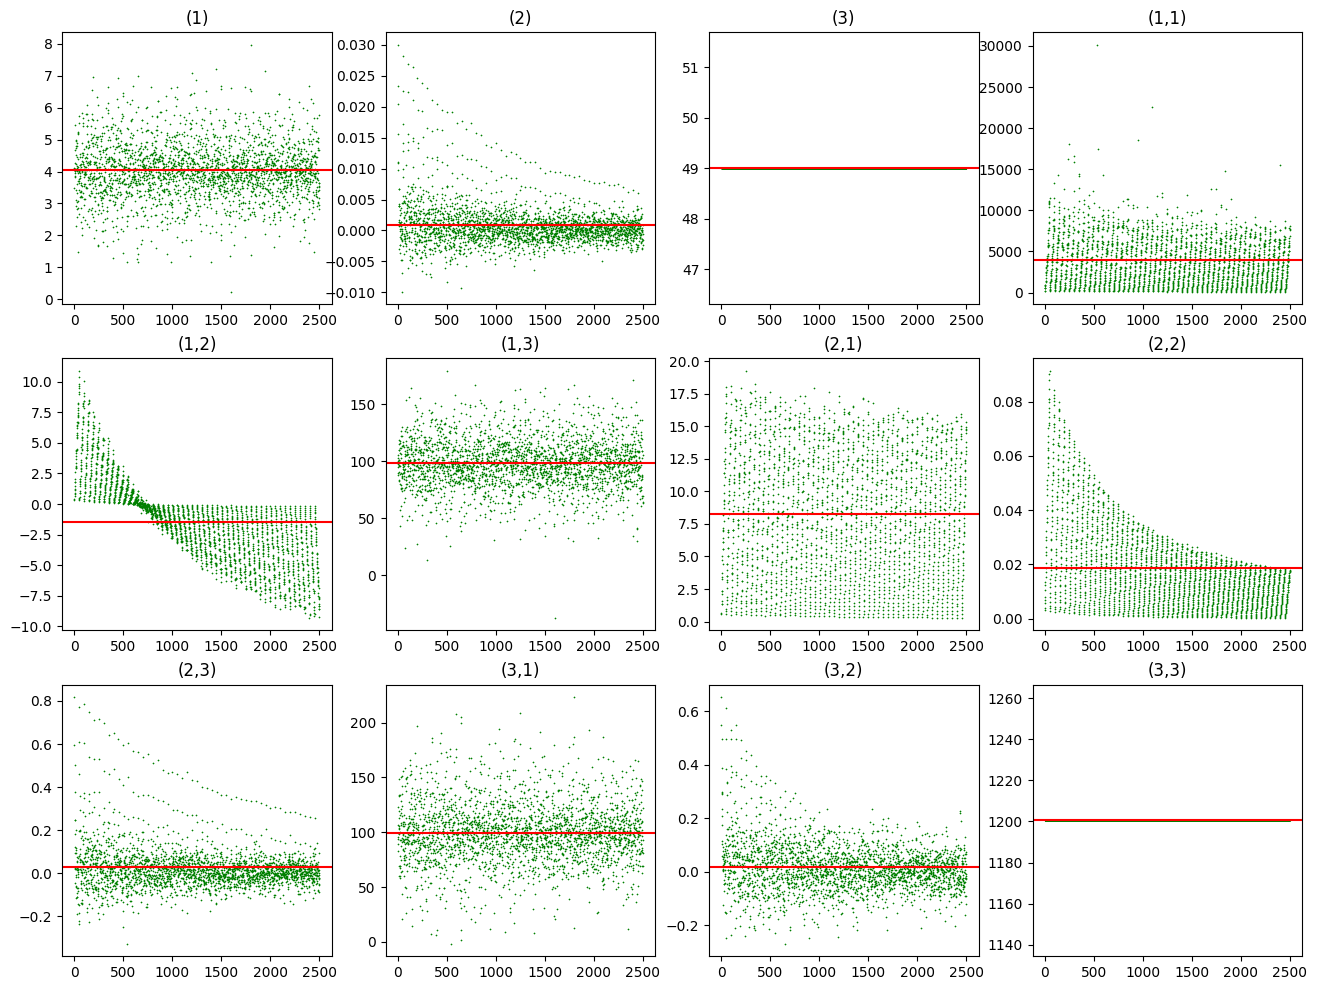

In [14]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_kappas_and_theta.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas_and_theta.T[i]), color='red')

#     Key  (1,2) takes on a negative value when the Kappas starts to take on a value above about 1.60
#   Keys (1,1), (1,2), (2,1) and (2,2) are structured such that for each new Kappa, the value of the Key starts around zero and grows as the value of Theta increases
#  Keys (1), (2), (1,3), (2,3), (3,1) and (3,2) have more chaotic patterns

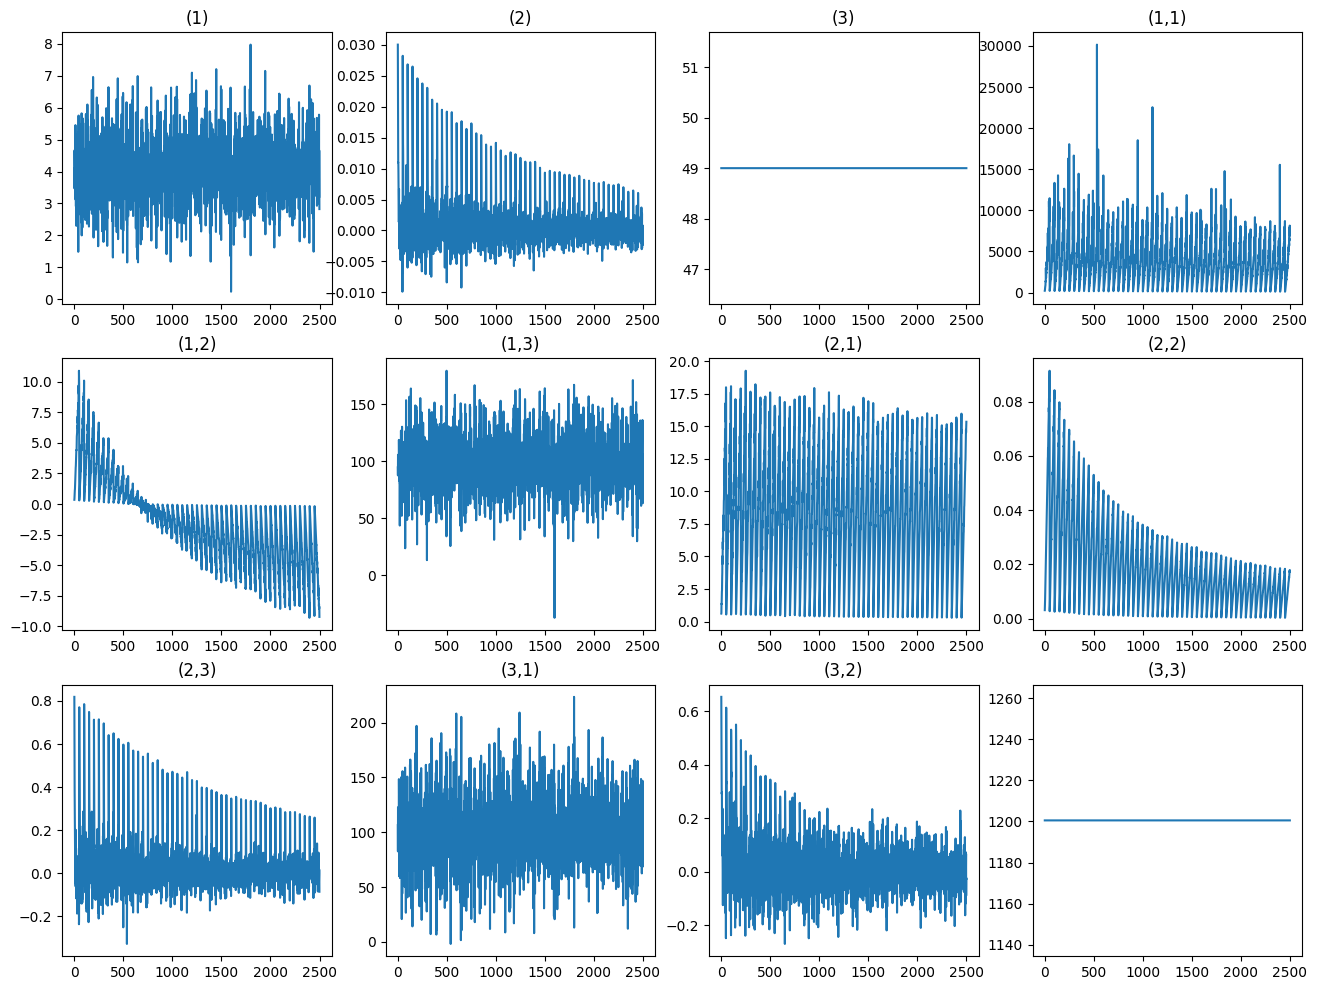

In [15]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_kappas_and_theta.T[i])

In [16]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for theta in by_parameter_2["by_thetas"]:
              for kappa in by_parameter_2["by_kappas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2500, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2500, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [17]:
number_of_loops=by_parameter_2["by_kappas"].shape[0]*by_parameter_2["by_thetas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [18]:
results_thetas_and_kappas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_thetas_and_kappas=results_thetas_and_kappas[0]
Exp_signatures_results_thetas_and_kappas=results_thetas_and_kappas[1]

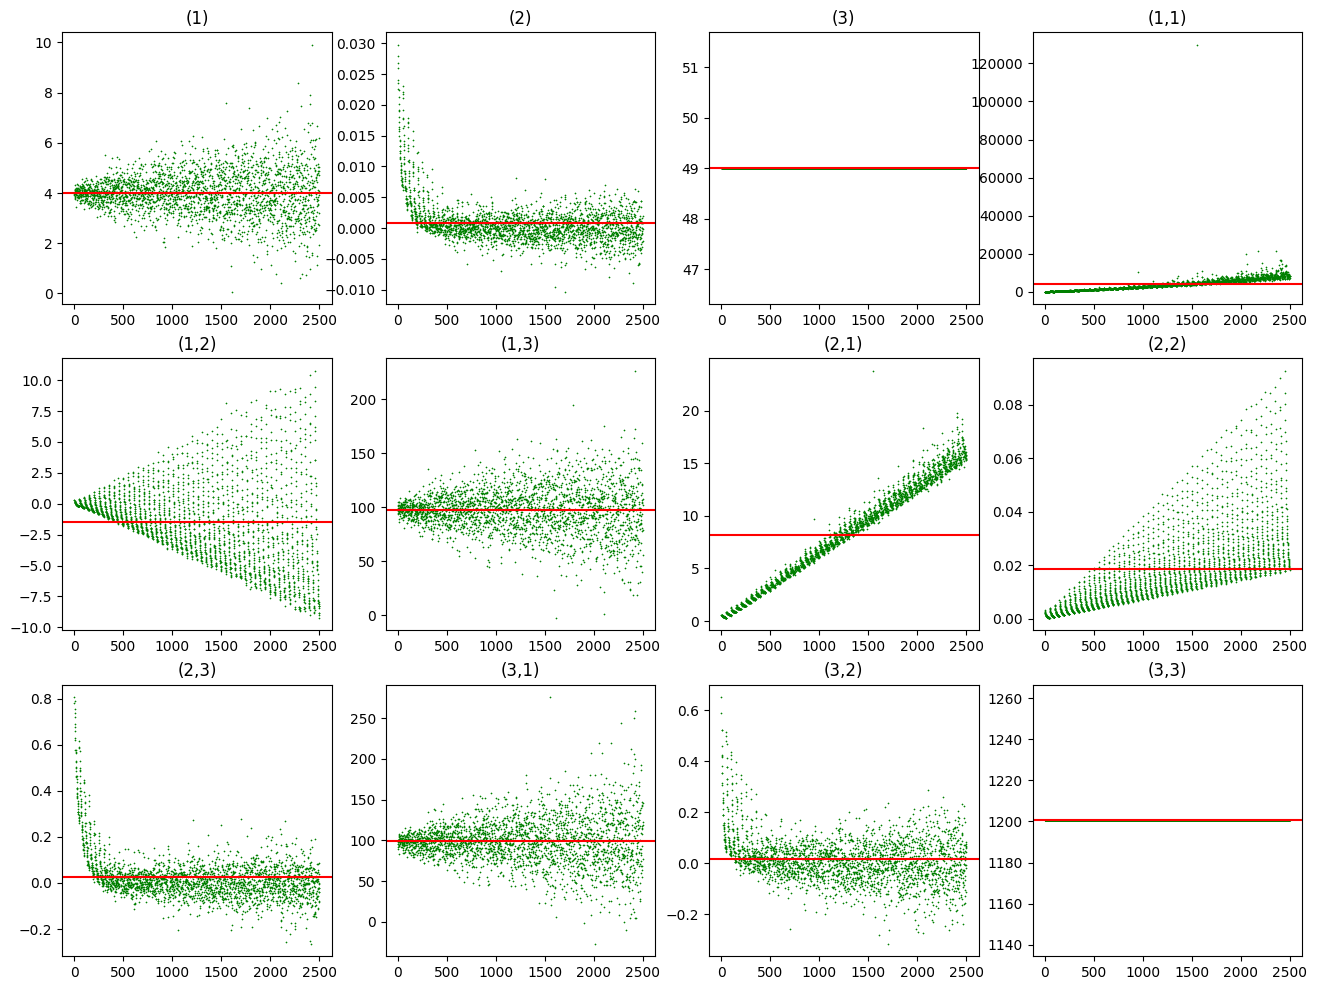

In [19]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_thetas_and_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas_and_kappas.T[i]), color='red')

#  Again Key  (1,2) takes on a negative value every time when the Kappas starts to take on a value above about 1.60
#     Keys (2) and (2,3) have similar patter to the plots that were simulated for variable Theta, namely for small theta have
#     bigger values, which are sharply reduced by a slight increase of theta
#     Keys (1), (1,3), (3,1) and (3,2) have more chaotic patterns
#   Keys (1,2), (2,1) and (2,2) are structured such that for each new Theta, the value of the Key starts from big value
#   and shrinks as the value of Kappa increases

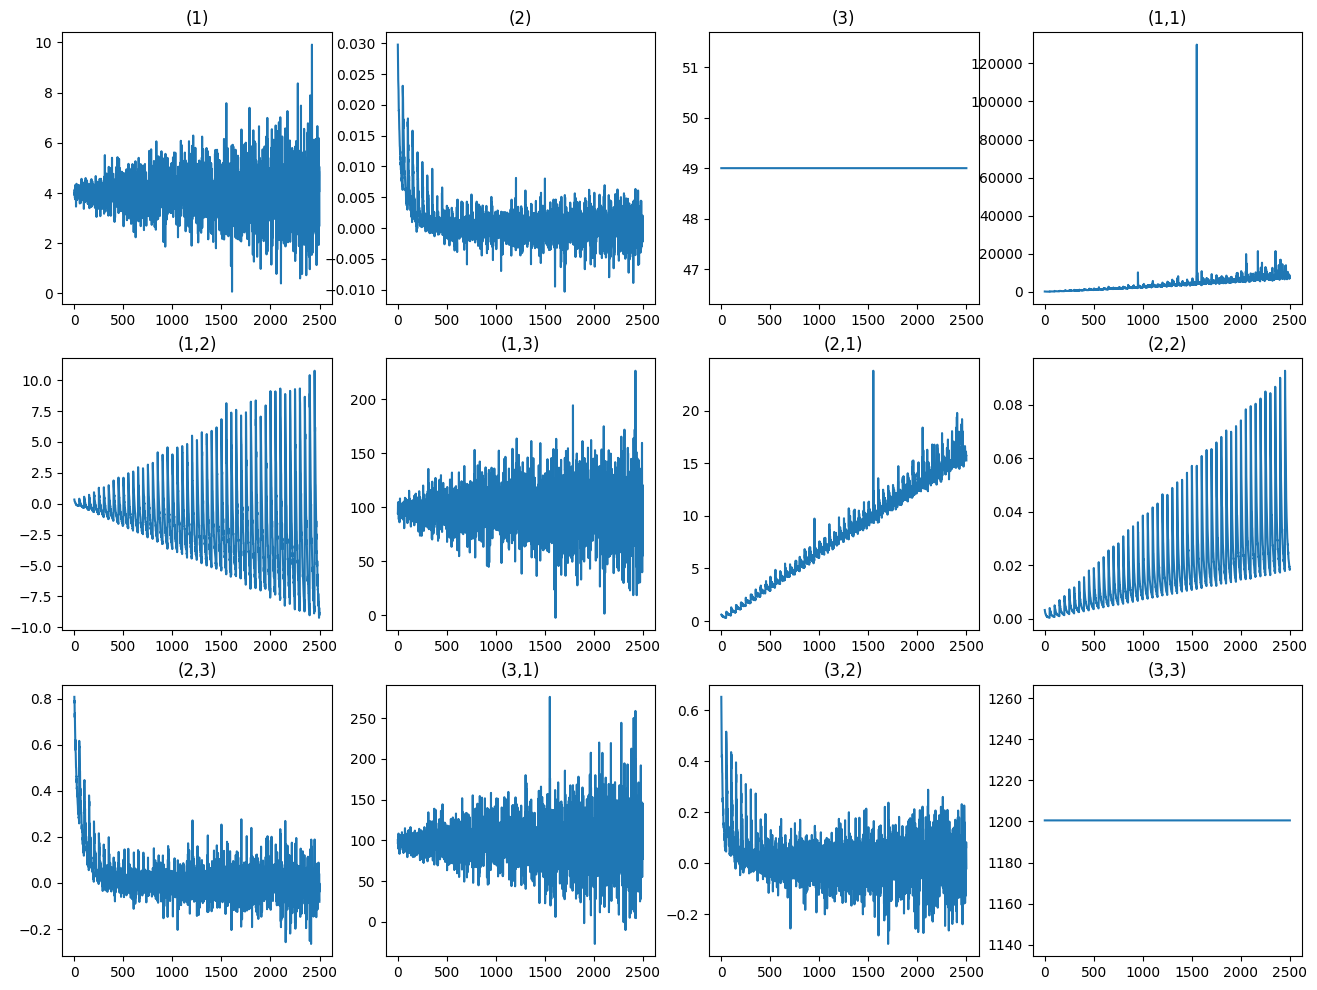

In [20]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_thetas_and_kappas.T[i])

In [22]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for theta in by_parameter_2["by_thetas"]:
              for sigma in by_parameter_2["by_sigmas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 50, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2915, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2915, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [23]:
number_of_loops=by_parameter_2["by_sigmas"].shape[0]*by_parameter_2["by_thetas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [24]:
results_thetas_and_sigmas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_thetas_and_sigmas=results_thetas_and_sigmas[0]
Exp_signatures_results_thetas_and_sigmas=results_thetas_and_sigmas[1]

In [25]:
Exp_signatures_results_thetas_and_sigmas.T[0].shape

torch.Size([2500])

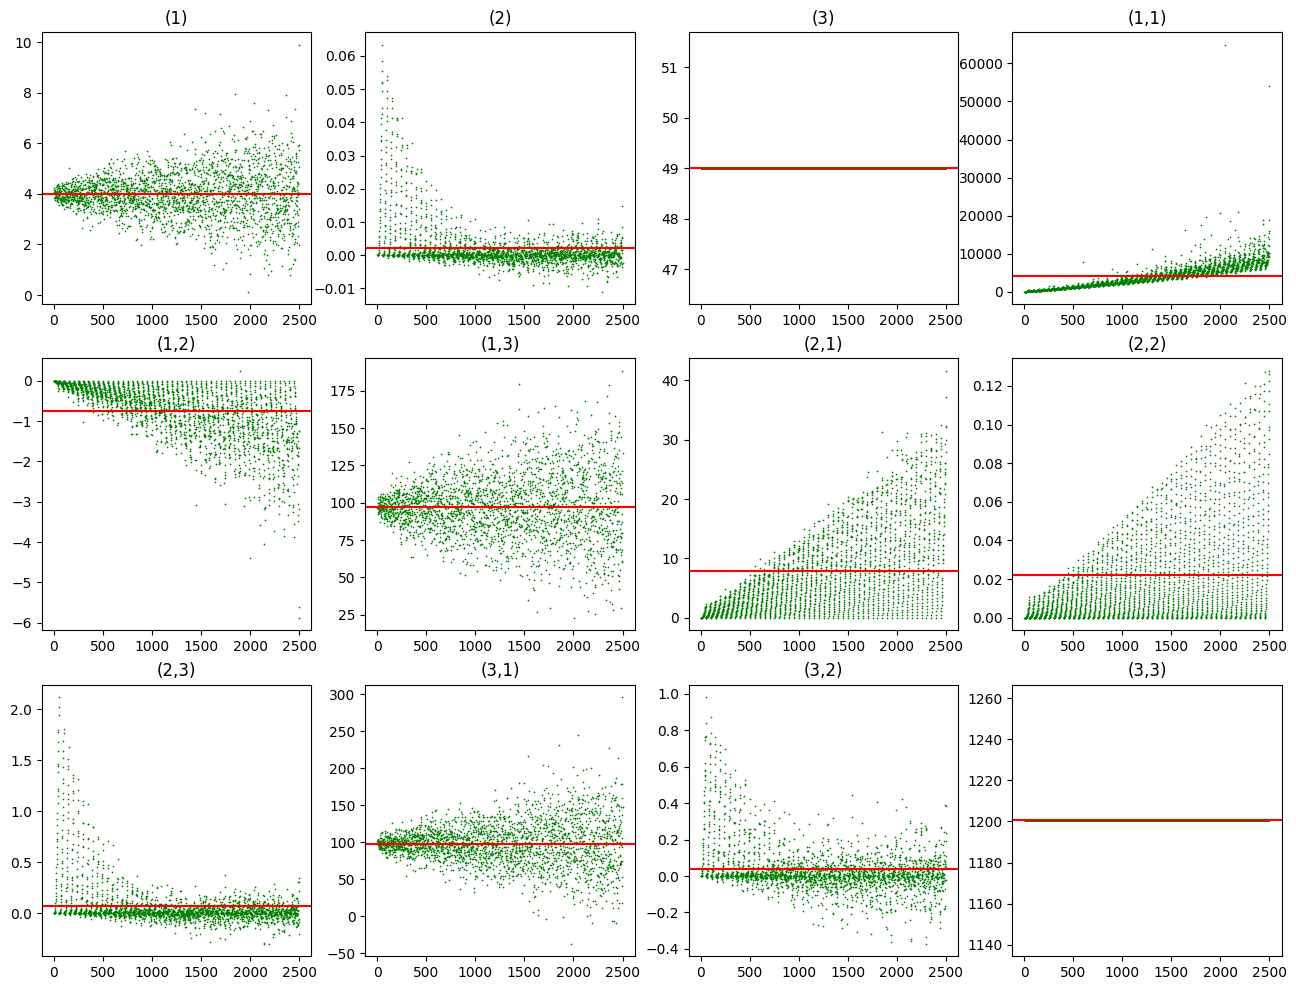

In [27]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_thetas_and_sigmas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas_and_sigmas.T[i]), color='red')

#     Key (1,2) takes only negative values
#     Keys (1,2), (2,1) and (2,2) habe a certatin structure such that, for each new value of theta (2,1) and (2,2) have a new
#     vertical line such that for bigger sigma key has a bigger value. Meanwhile, (1,2) has an opposite structure, such that
#     for each new value of sigma key has lower value. For all these keys we have one thing in commmon,
#     i.e. for bigger theta we have a bigger dispersion.
#      Keys (1), (1,3) and (3,1) are obviously have higher fluctuation and mor chaotic structure.
#       Keys (2), (2,3) and (3,2) have some similar structure to Keys (1,2), (2,1) and (2,2) at the begining,
#       but the bigger theta the more chaotic structure they have.

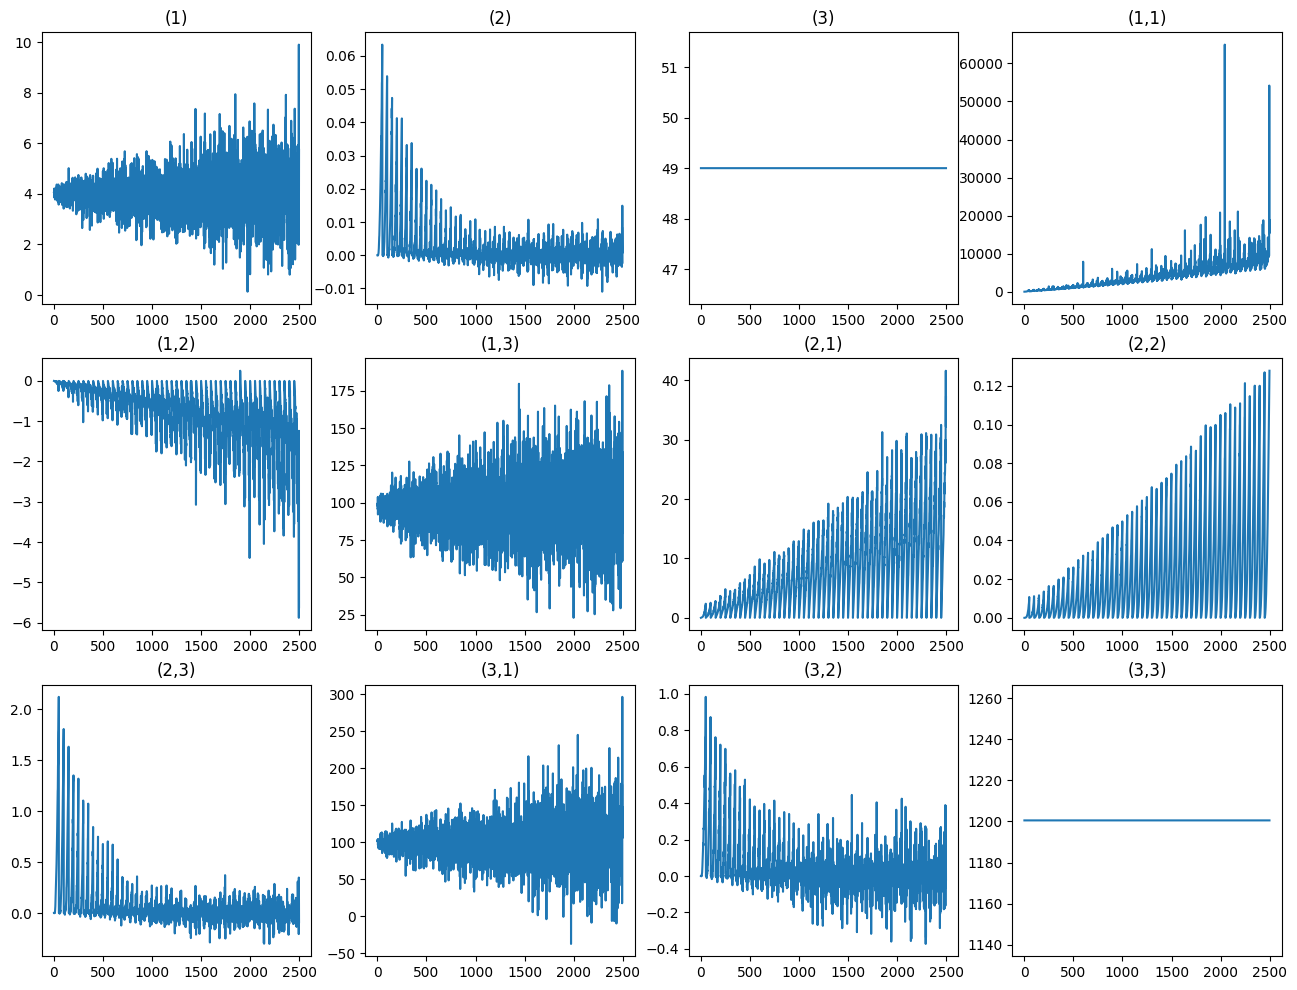

In [28]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_thetas_and_sigmas.T[i])

In [29]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for sigma in by_parameter_2["by_sigmas"]:
              for theta in by_parameter_2["by_thetas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2915, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2915, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [30]:
results_sigmas_and_thetas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_sigmas_and_thetas=results_sigmas_and_thetas[0]
Exp_signatures_results_sigmas_and_thetas=results_sigmas_and_thetas[1]

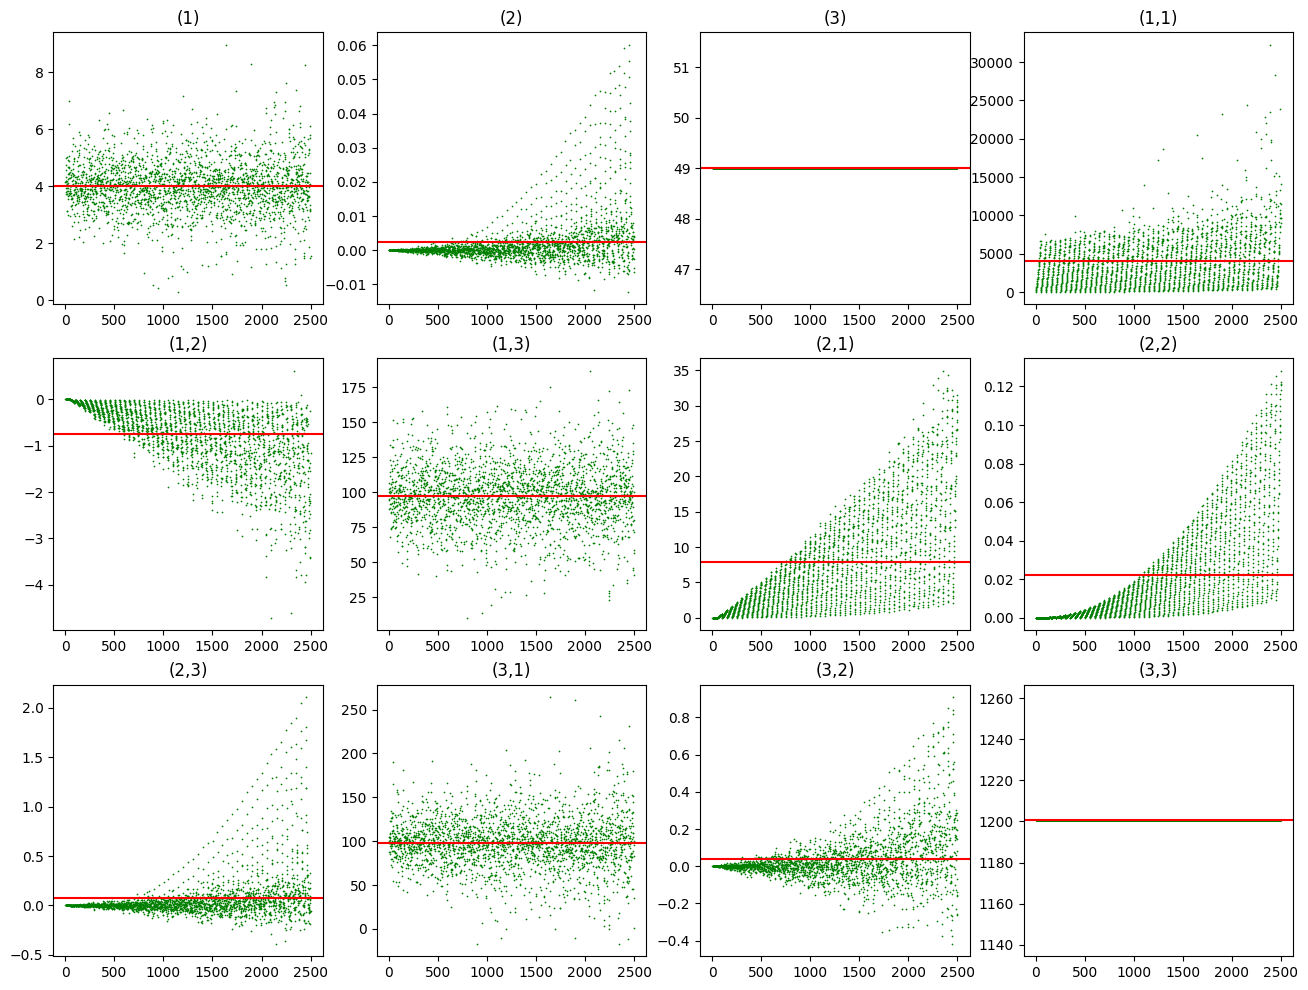

In [31]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_sigmas_and_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_sigmas_and_thetas.T[i]), color='red')

#     Key (1,2) takes only negative values
#     Keys (1,2), (2,1) and (2,2) habe a certatin structure such that, for each new value of sigma (2,1) and (2,2) have a new
#     vertical line such that for bigger theta key has a bigger value. Meanwhile, (1,2) has an opposite structure, such that
#     for each new value of theta key has lower value. For all these keys we have one thing in commmon,
#     i.e. for bigger sigma we have a bigger dispersion.
#      Keys (1), (1,3) and (3,1) are obviously have higher fluctuation and mor chaotic structure.
#       Key (1,1) has similar structure to (2,1) but does not grow much with bigger thetas and sigmas, however with bigger
#       sigmas it has more outlires
#       Keys (2), (2,3) and (3,2) have some similar structure to Keys (1,2), (2,1) and (2,2) at the ending,
#       but the bigger sigma the more dispersion they have.

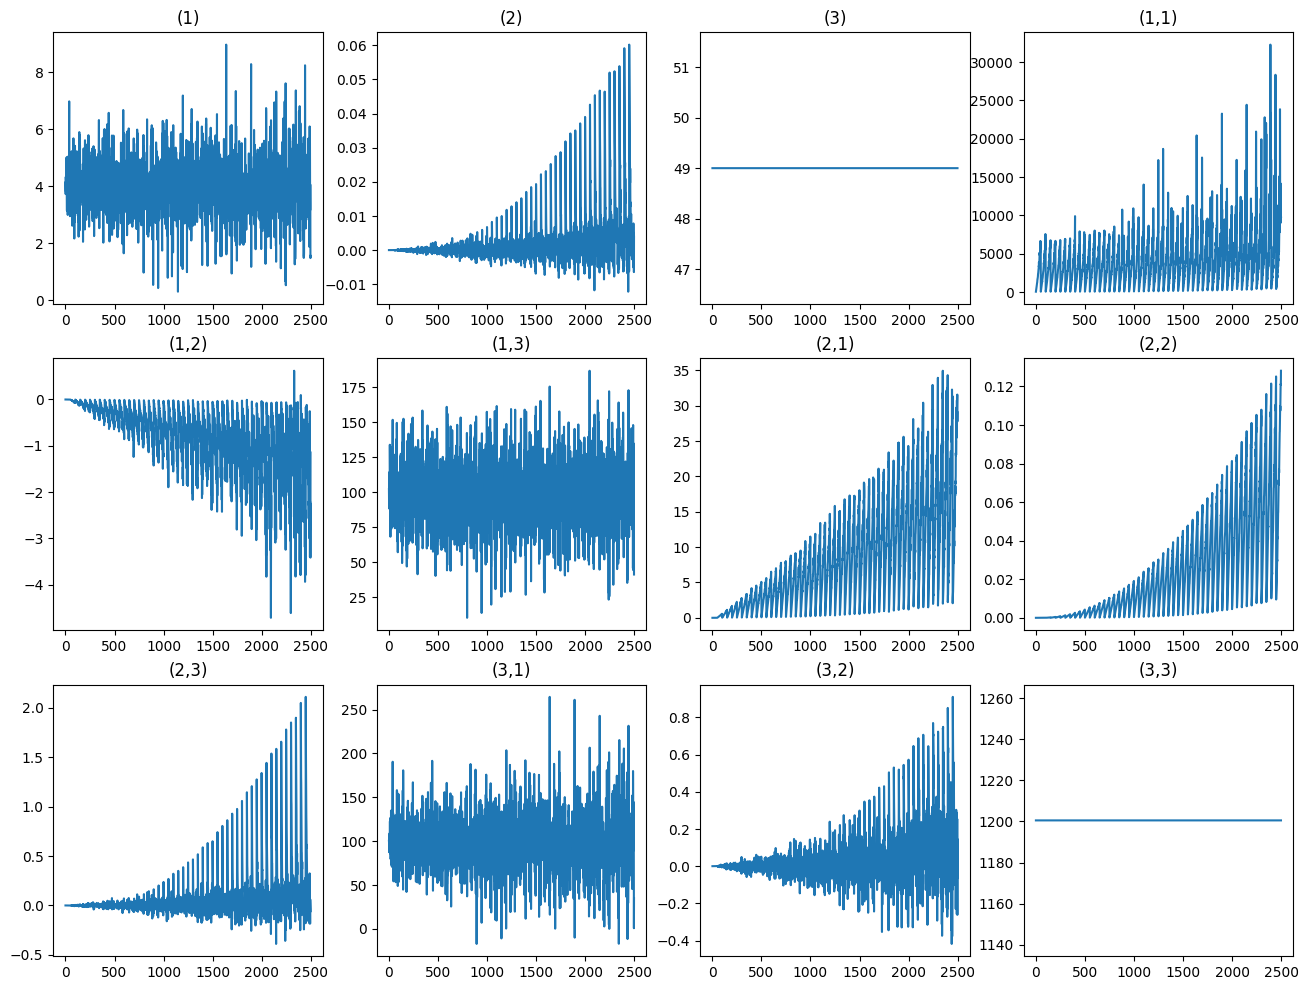

In [32]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_sigmas_and_thetas.T[i])

In [33]:
number_of_loops=by_parameter_2["by_sigmas"].shape[0]*by_parameter_2["by_kappas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [34]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for sigma in by_parameter_2["by_sigmas"]:
              for kappa in by_parameter_2["by_kappas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2500, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2500, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [35]:
results_sigmas_and_kappas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_sigmas_and_kappas=results_sigmas_and_kappas[0]
Exp_signatures_results_sigmas_and_kappas=results_sigmas_and_kappas[1]

In [36]:
Exp_signatures_results_sigmas_and_kappas.T[1].shape

torch.Size([2500])

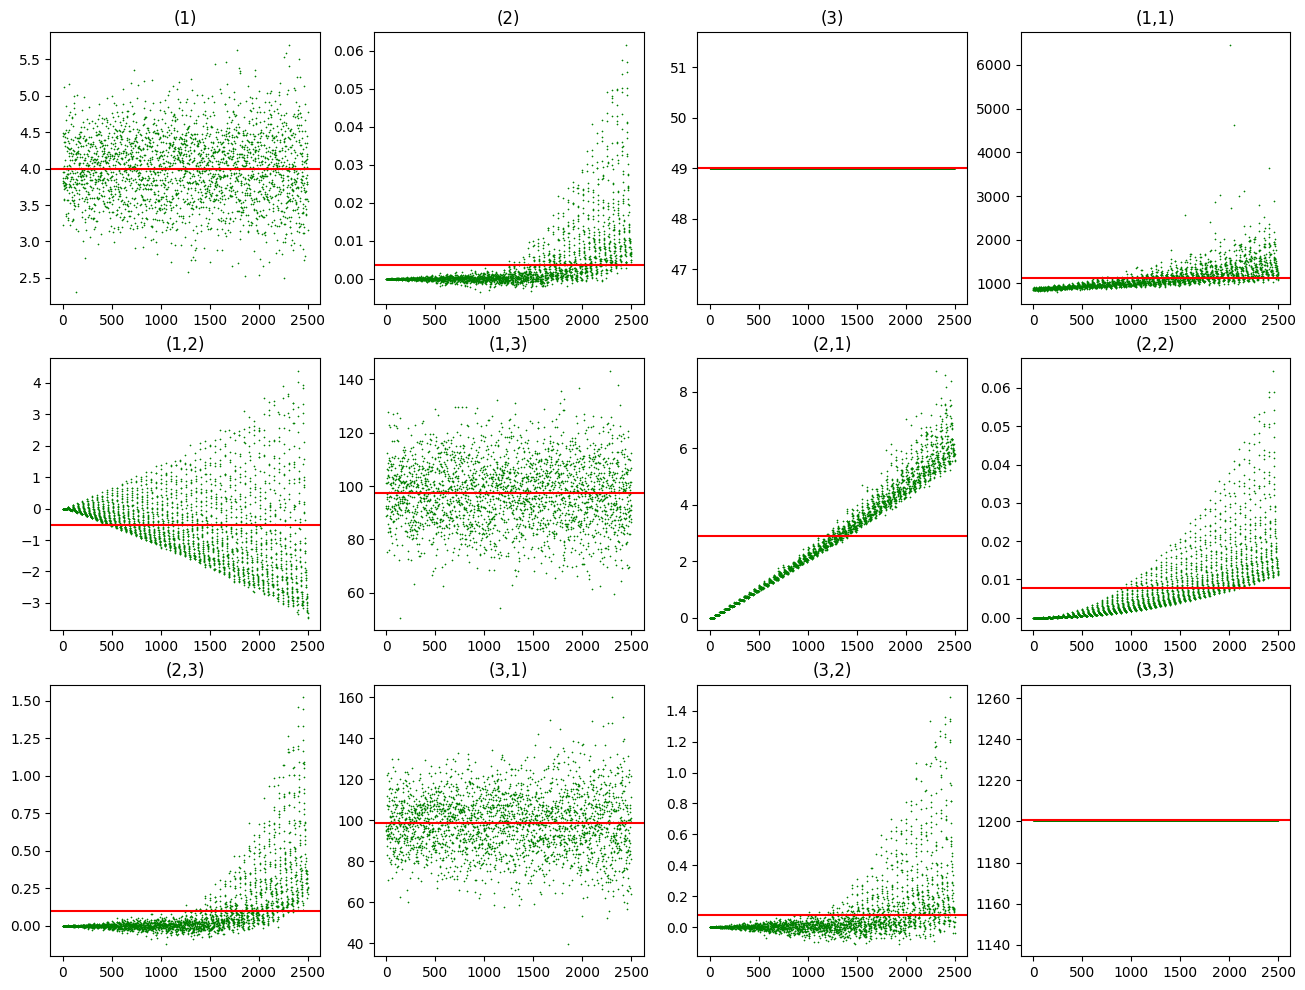

In [37]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_sigmas_and_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_sigmas_and_kappas.T[i]), color='red')

#      Keys (1), (1,3) and (3,1)  obviously have higher fluctuation and more chaotic structure.
#       Key (1,2) takes both postive and negative values. It starts to take negative when kappa becomes greater then 1.60....
#       

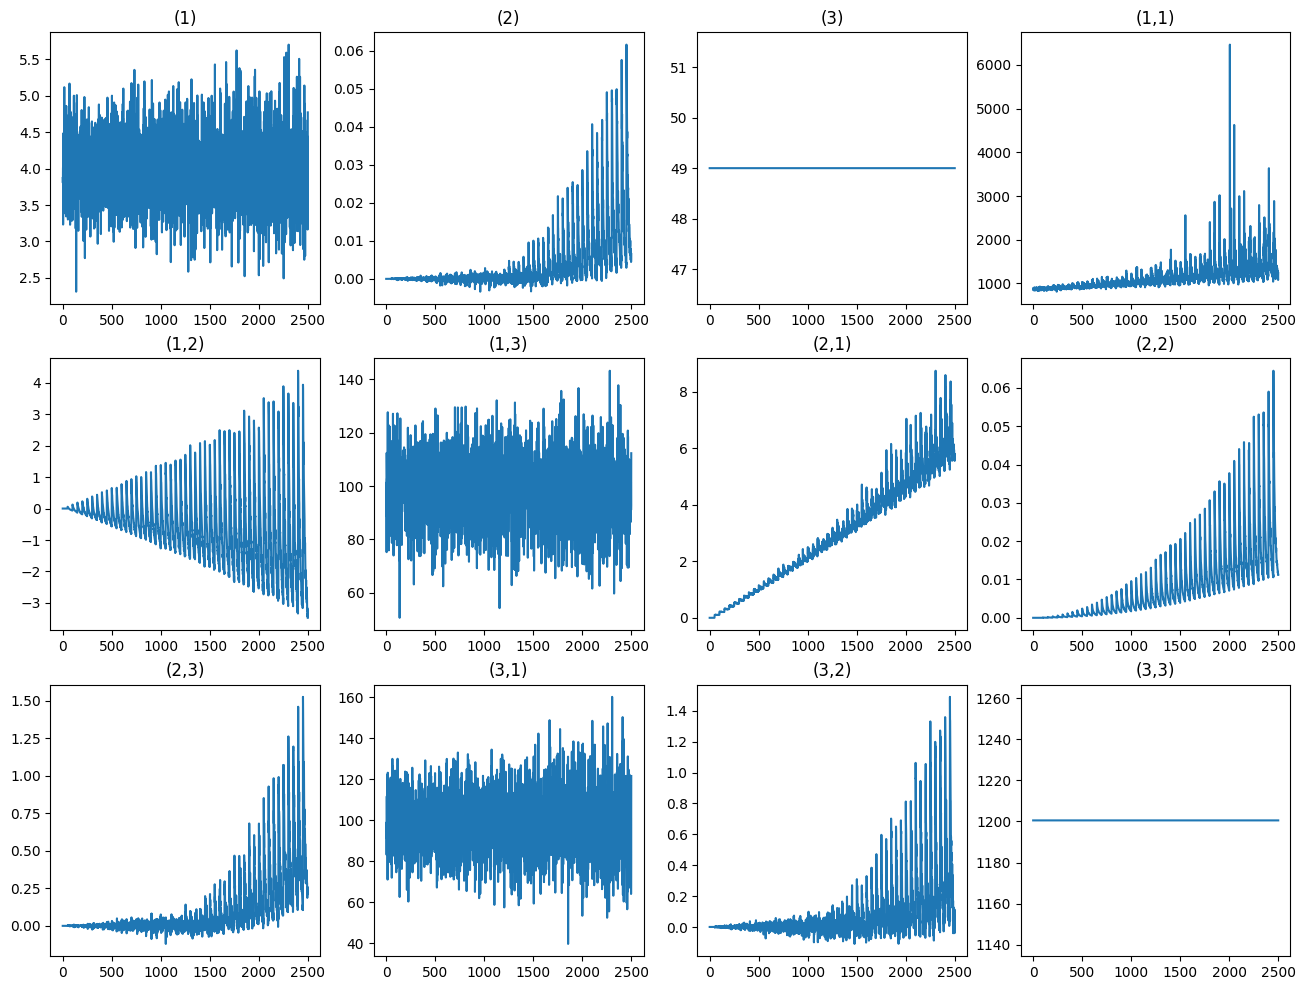

In [38]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_sigmas_and_kappas.T[i])

In [39]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for kappa in by_parameter_2["by_kappas"]:
              for sigma in by_parameter_2["by_sigmas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([512, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([512, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [40]:
results_kappas_and_sigmas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_kappas_and_sigmas=results_kappas_and_sigmas[0]
Exp_signatures_results_kappas_and_sigmas=results_kappas_and_sigmas[1]

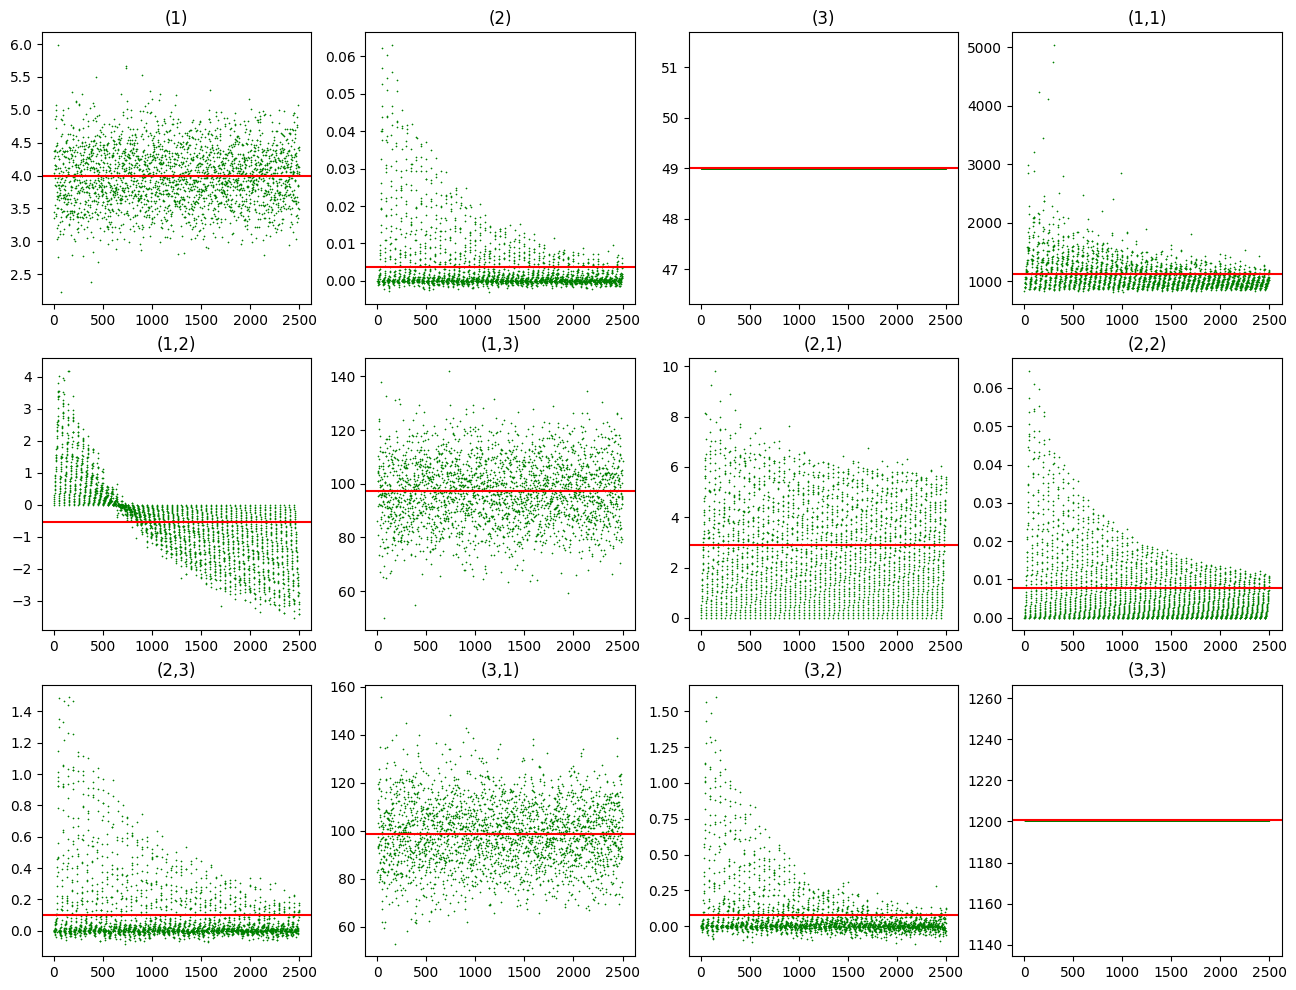

In [41]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_kappas_and_sigmas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas_and_sigmas.T[i]), color='red')

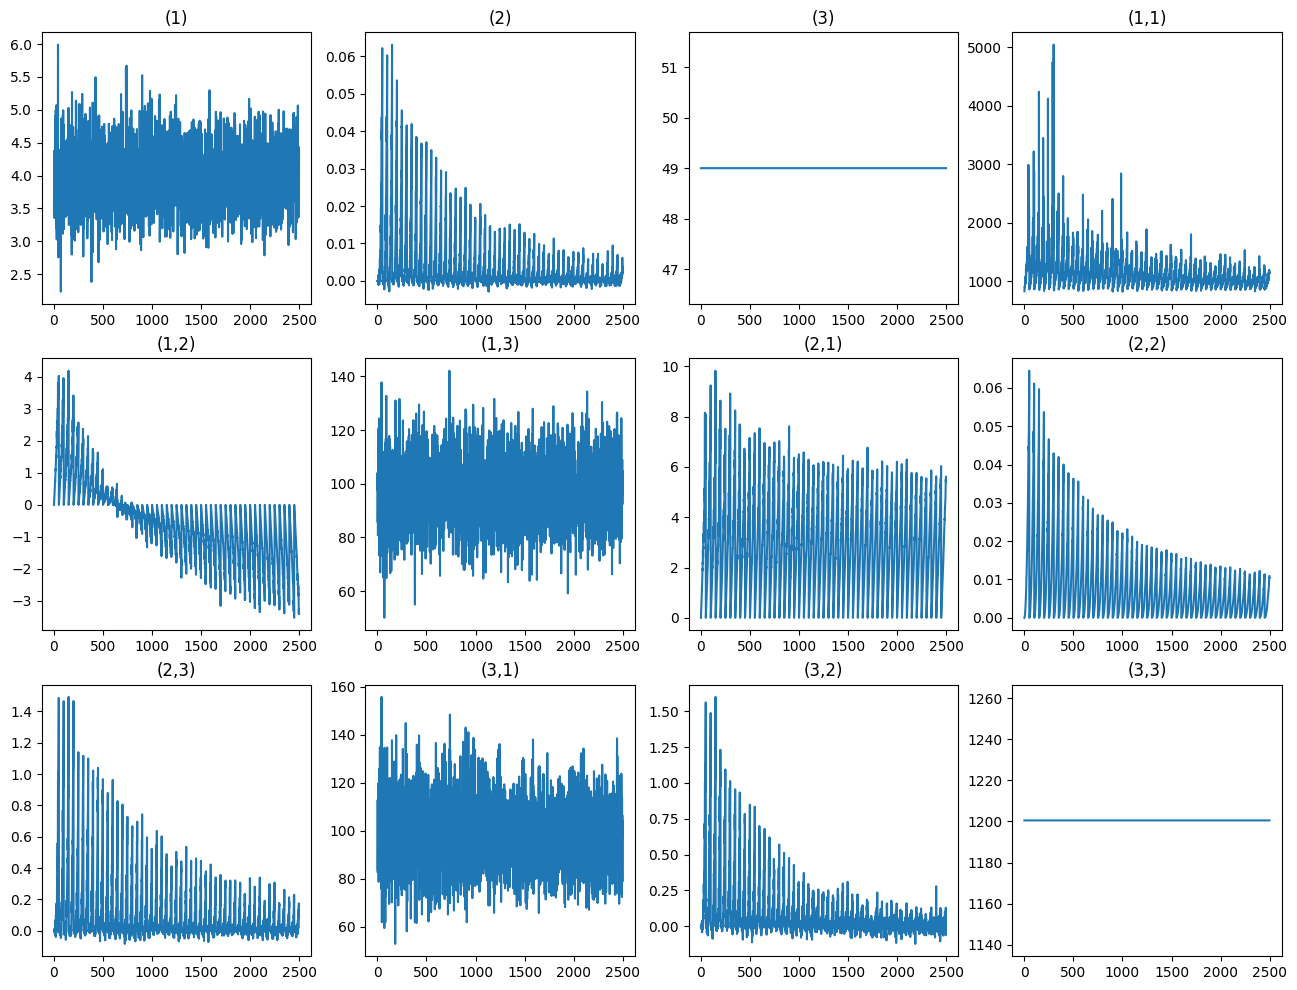

In [42]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_kappas_and_sigmas.T[i])

In [43]:
number_of_loops=by_parameter_2["by_rhos"].shape[0]*by_parameter_2["by_sigmas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [44]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for rho in by_parameter_2["by_rhos"]:
              for sigma in by_parameter_2["by_sigmas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([3025, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([3025, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [45]:
results_rhos_and_sigmas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_rhos_and_sigmas=results_rhos_and_sigmas[0]
Exp_signatures_results_rhos_and_sigmas=results_rhos_and_sigmas[1]

In [46]:
Exp_signatures_results_rhos_and_sigmas.T[1].shape

torch.Size([2500])

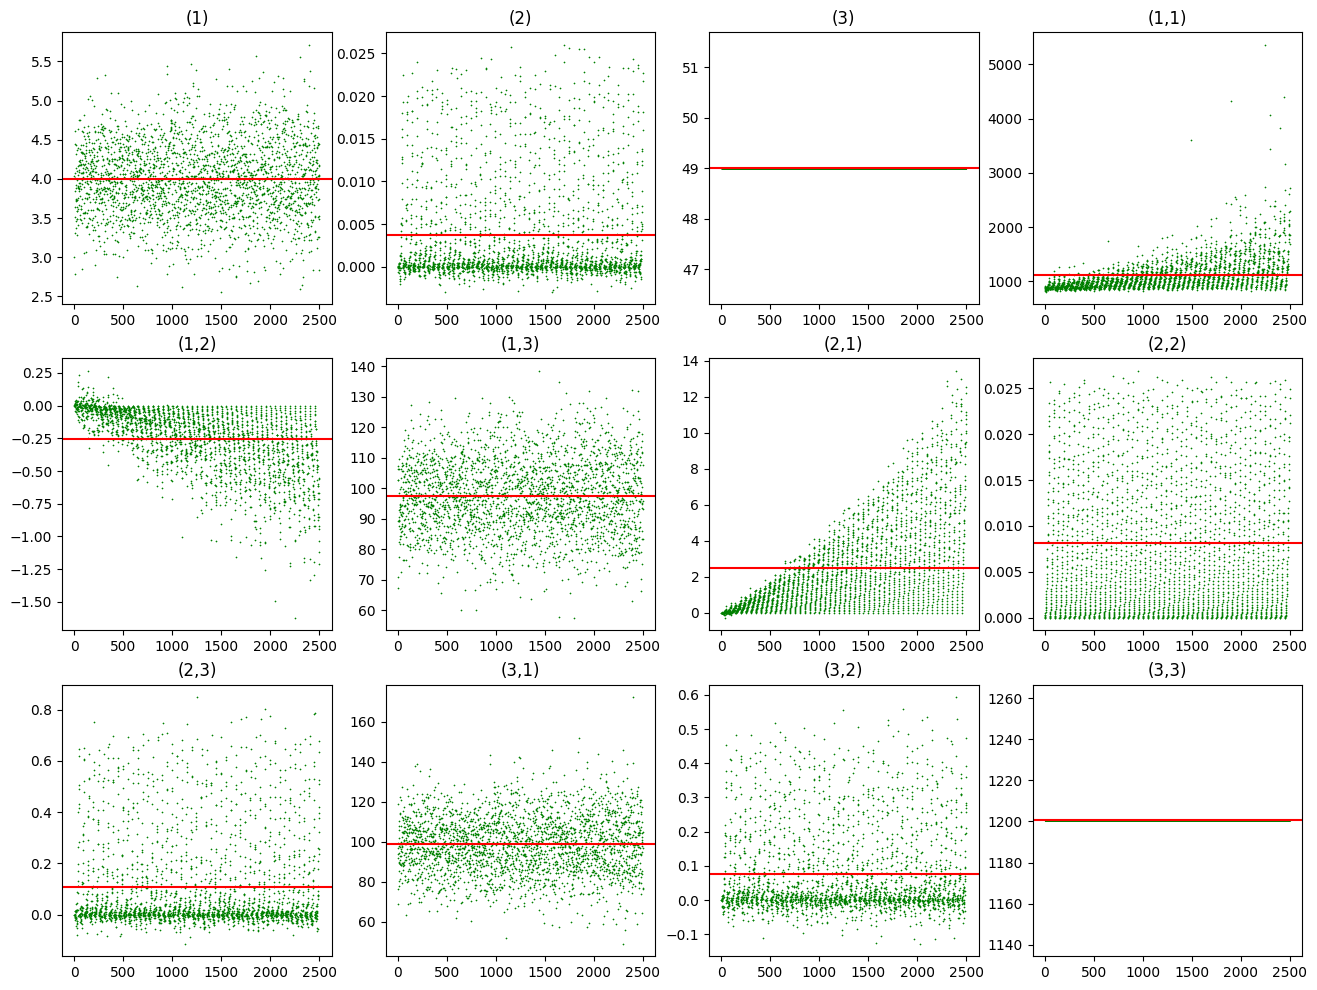

In [47]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_rhos_and_sigmas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_rhos_and_sigmas.T[i]), color='red')

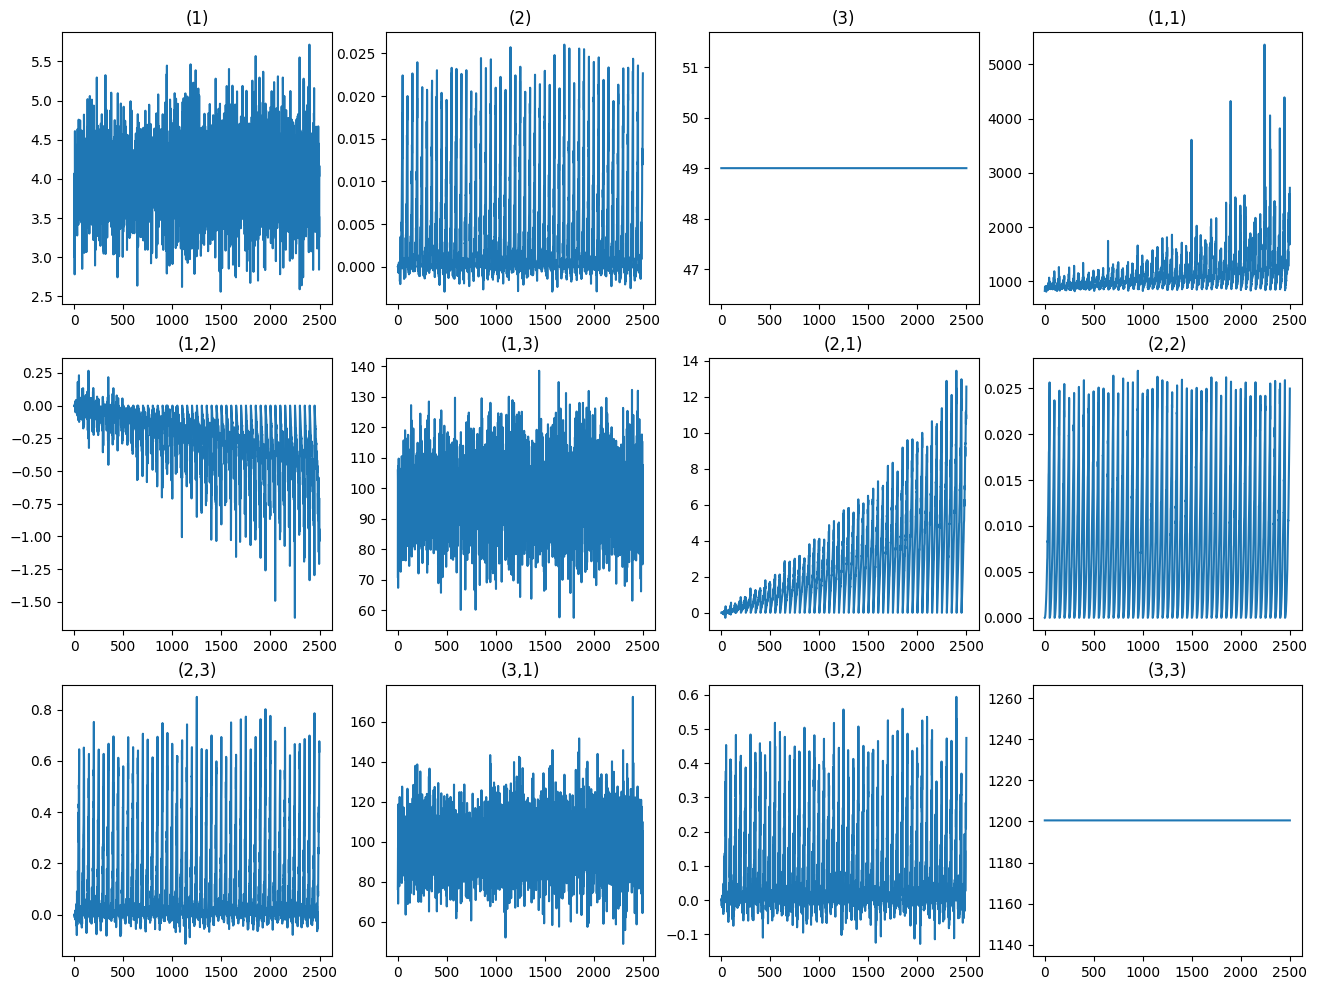

In [48]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_rhos_and_sigmas.T[i])

In [49]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for sigma in by_parameter_2["by_sigmas"]:
              for rho in by_parameter_2["by_rhos"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([3025, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([3025, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [50]:
results_sigmas_and_rhos=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_sigmas_and_rhos=results_sigmas_and_rhos[0]
Exp_signatures_results_sigmas_and_rhos=results_sigmas_and_rhos[1]

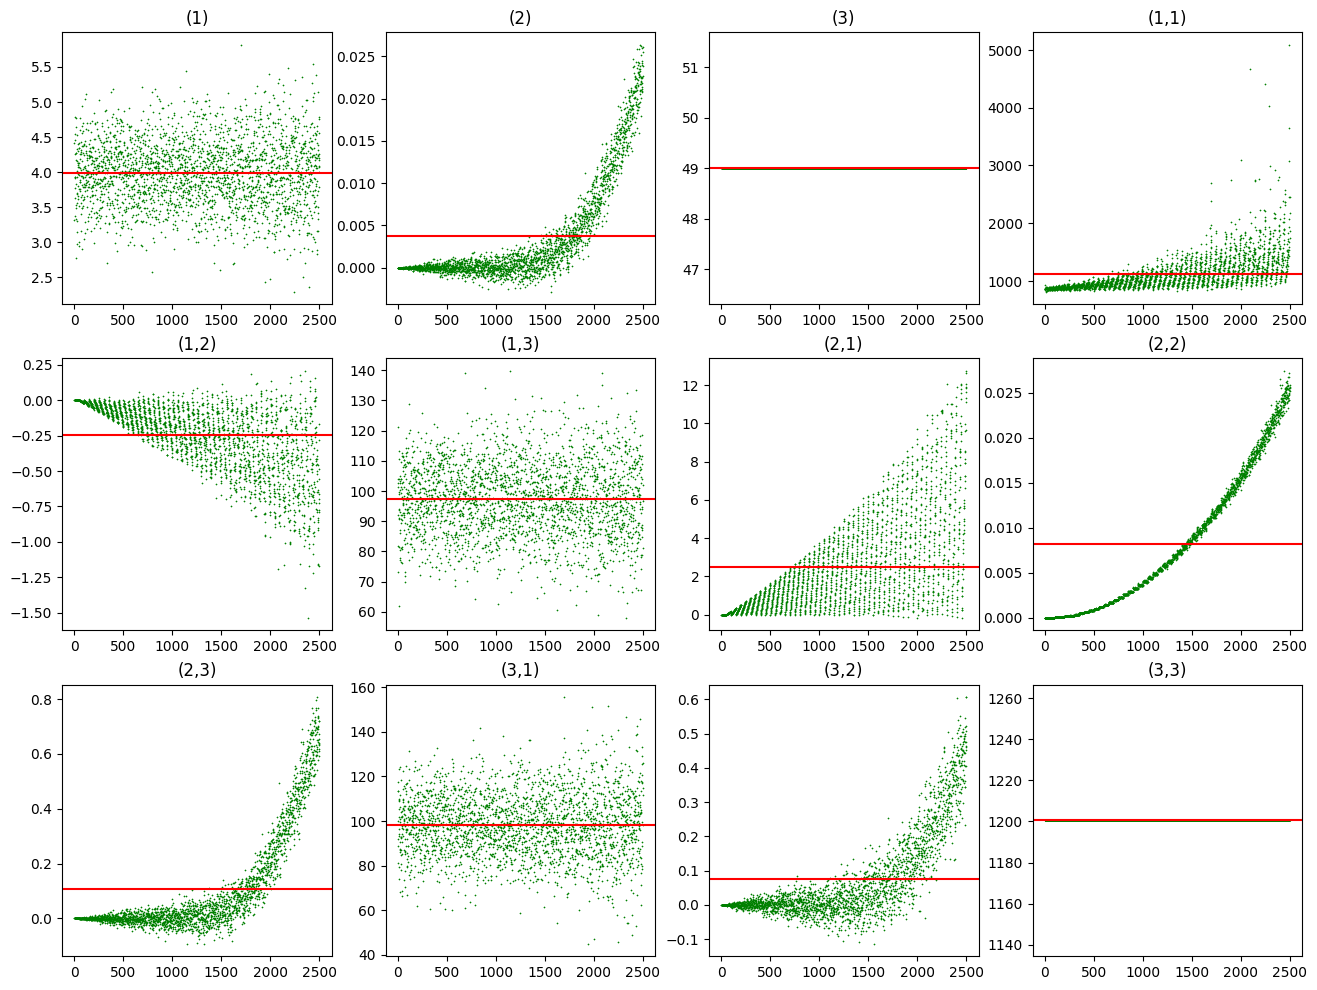

In [51]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_sigmas_and_rhos.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_sigmas_and_rhos.T[i]), color='red')

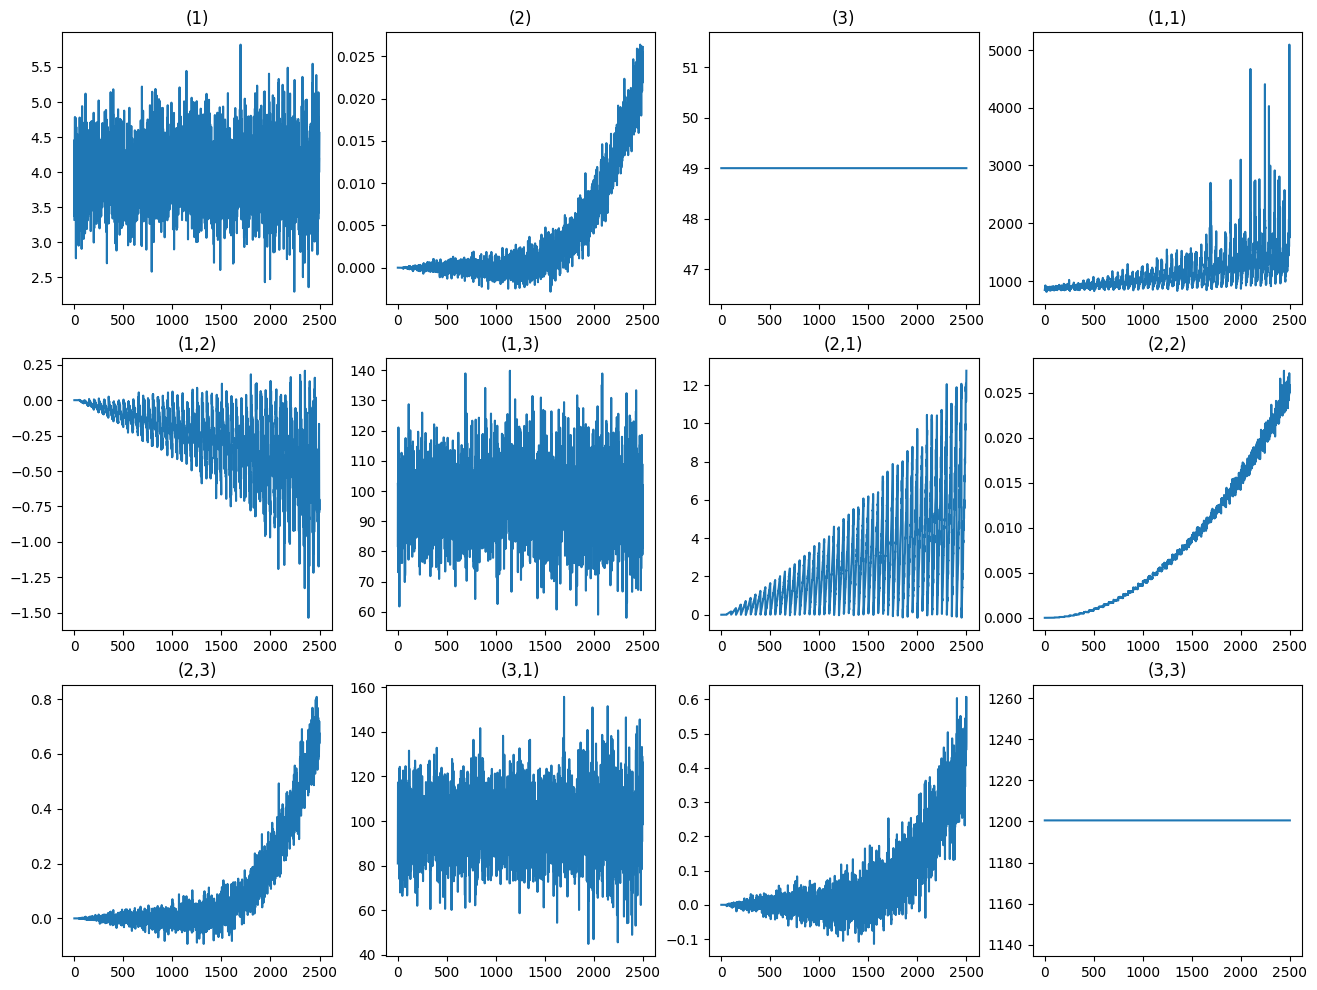

In [52]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_sigmas_and_rhos.T[i])

In [53]:
number_of_loops=by_parameter_2["by_rhos"].shape[0]*by_parameter_2["by_thetas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [54]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for theta in by_parameter_2["by_thetas"]:
              for rho in by_parameter_2["by_rhos"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2915, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2915, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [55]:
results_thetas_and_rhos=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_thetas_and_rhos=results_thetas_and_rhos[0]
Exp_signatures_results_thetas_and_rhos=results_thetas_and_rhos[1]

In [56]:
Exp_signatures_results_thetas_and_rhos.T[1].shape

torch.Size([2500])

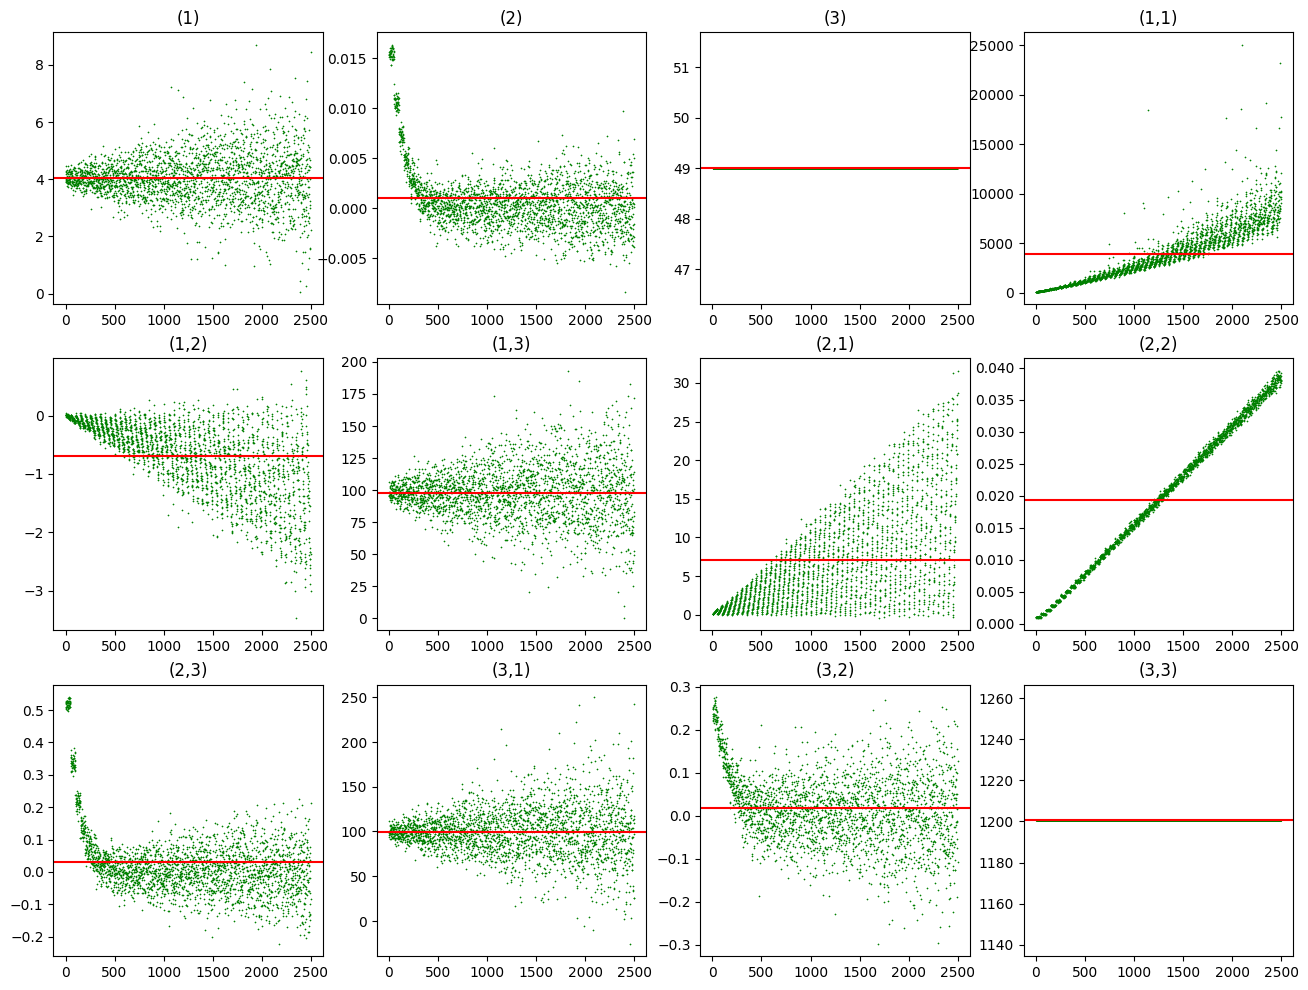

In [57]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_thetas_and_rhos.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_thetas_and_rhos.T[i]), color='red')

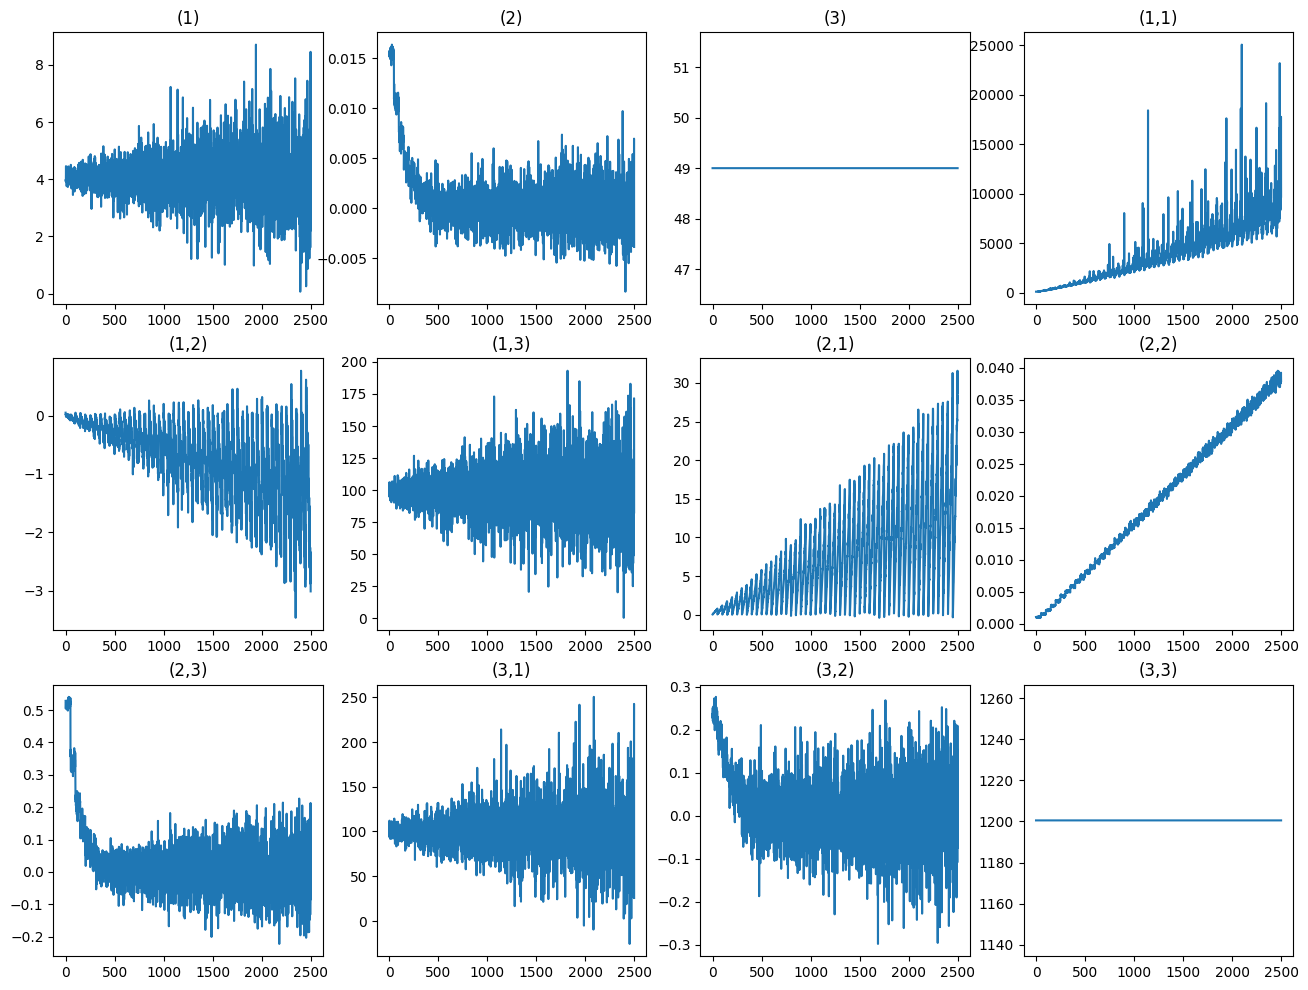

In [58]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_thetas_and_rhos.T[i])

In [59]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for rho in by_parameter_2["by_rhos"]:
              for theta in by_parameter_2["by_thetas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2915, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2915, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [60]:
results_rhos_and_thetas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_rhos_and_thetas=results_rhos_and_thetas[0]
Exp_signatures_results_rhos_and_thetas=results_rhos_and_thetas[1]

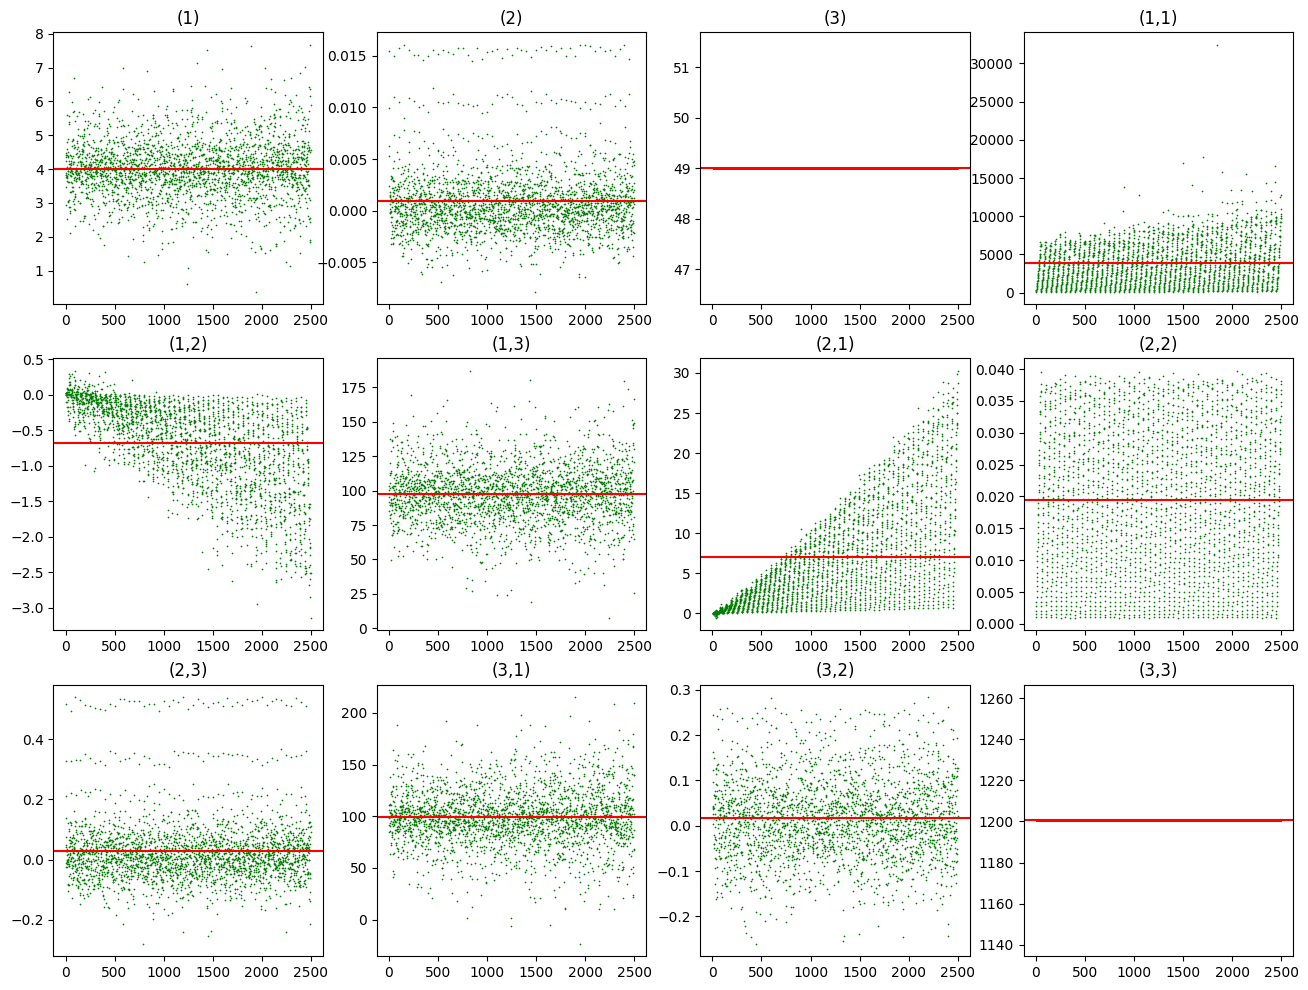

In [61]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_rhos_and_thetas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_rhos_and_thetas.T[i]), color='red')

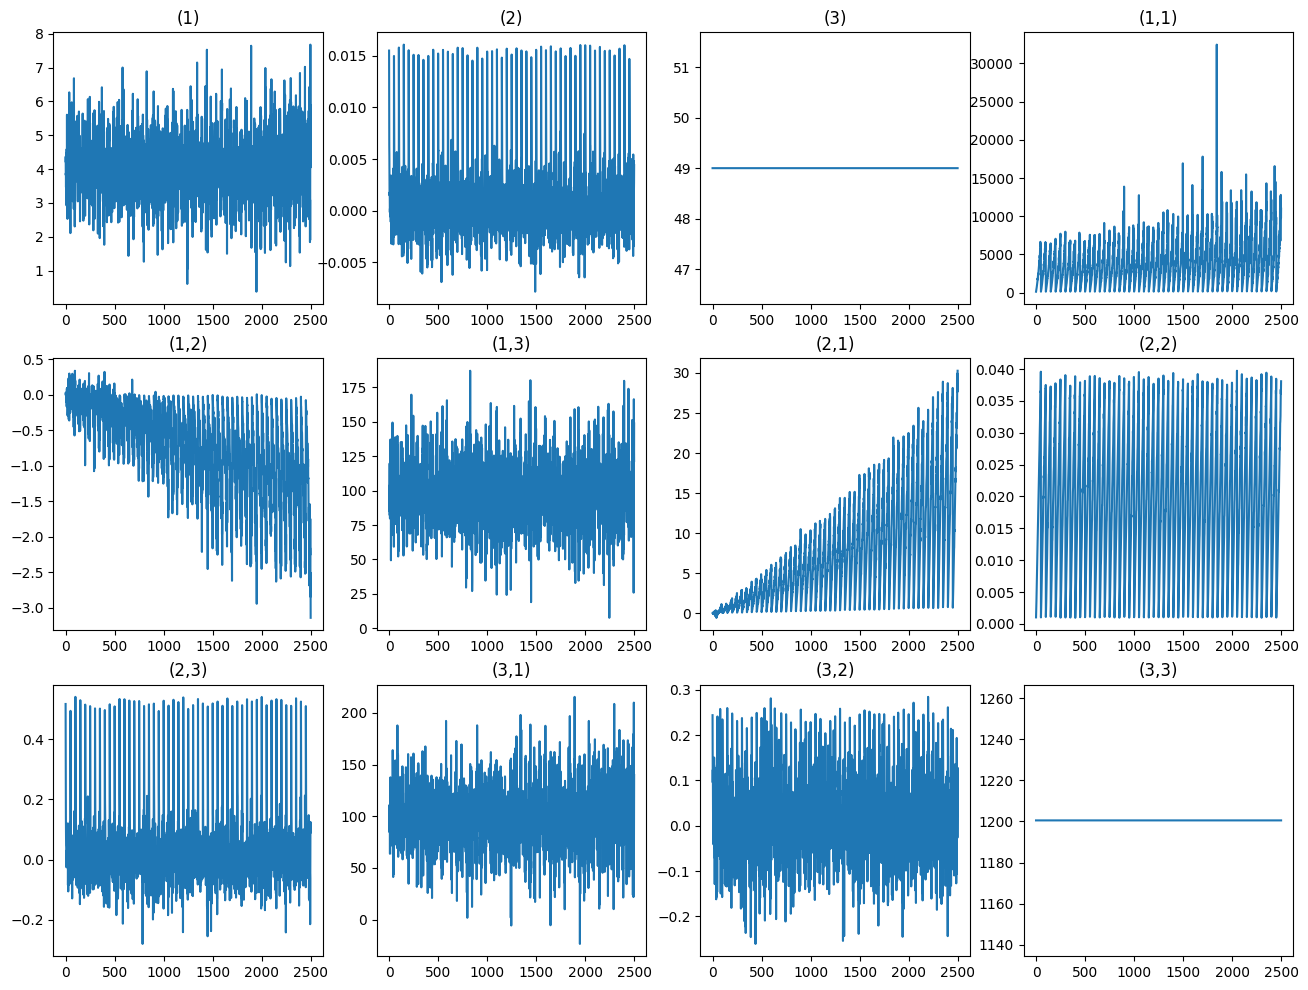

In [62]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_rhos_and_thetas.T[i])

In [63]:
number_of_loops=by_parameter_2["by_rhos"].shape[0]*by_parameter_2["by_kappas"].shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
sign_ps_signatory_differentranges[0].shape

torch.Size([10000, 12])

In [64]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for rho in by_parameter_2["by_rhos"]:
              for kappa in by_parameter_2["by_kappas"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2475, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2475, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [65]:
results_rhos_and_kappas=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_rhos_and_kappas=results_rhos_and_kappas[0]
Exp_signatures_results_rhos_and_kappas=results_rhos_and_kappas[1]

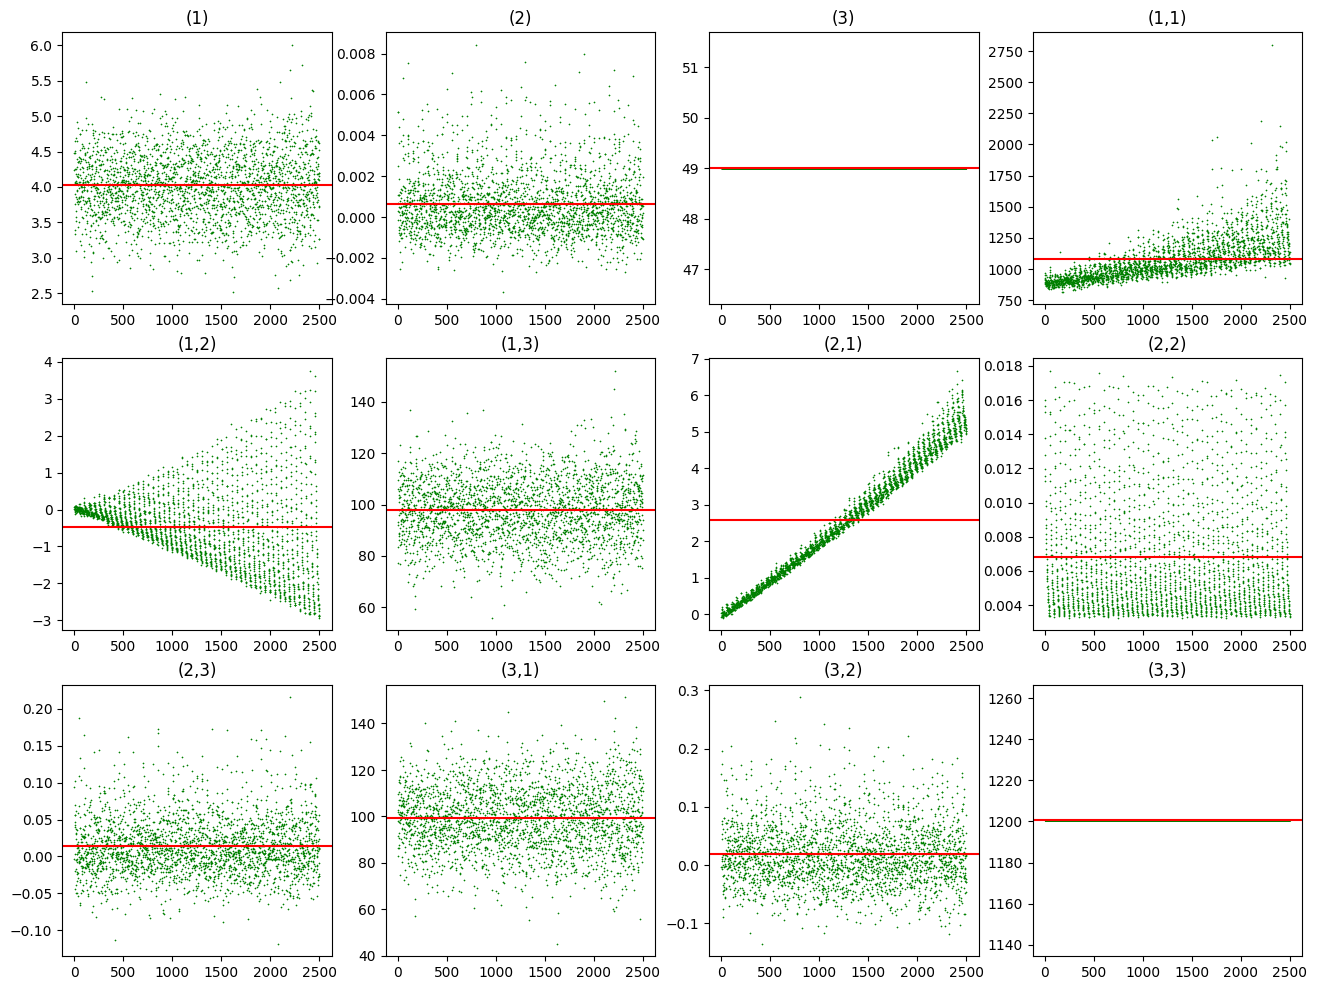

In [66]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_rhos_and_kappas.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_rhos_and_kappas.T[i]), color='red')

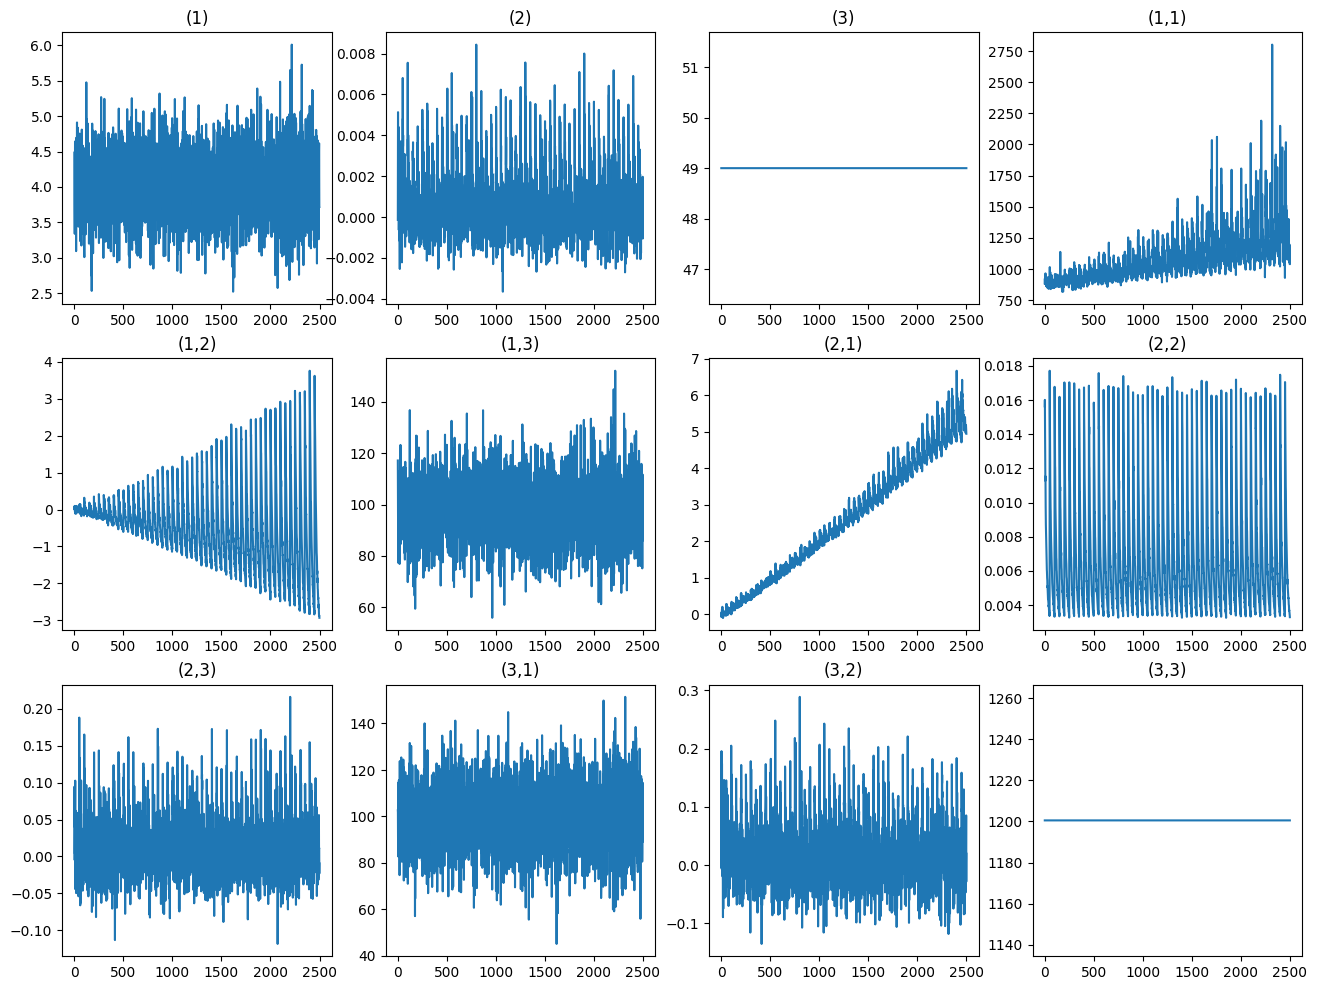

In [67]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_rhos_and_kappas.T[i])

In [68]:
def signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for kappa in by_parameter_2["by_kappas"]:
              for rho in by_parameter_2["by_rhos"]:
                        # Caclulation of 10000 paths of prices and sigmas
                        prices_1, sigs_1 = generate_heston_paths(S, T, r, kappa, theta, theta, rho, sigma, steps, paths,
                                                                 return_vol=True)
                        for j in range(paths):
                            prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                        #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

                        sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
                        #     shape of  sign_ps_signatory_differentranges=torch.Size([2475, 10000, 12])

                        Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
                        #     shape of  Exp_sign_signatory_results=torch.Size([2475, 12])

                        count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [69]:
results_kappas_and_rhos=signatures_calculations_with_timearray(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_result_kappas_and_rhos=results_kappas_and_rhos[0]
Exp_signatures_results_kappas_and_rhos=results_kappas_and_rhos[1]

torch.Size([2500, 12])

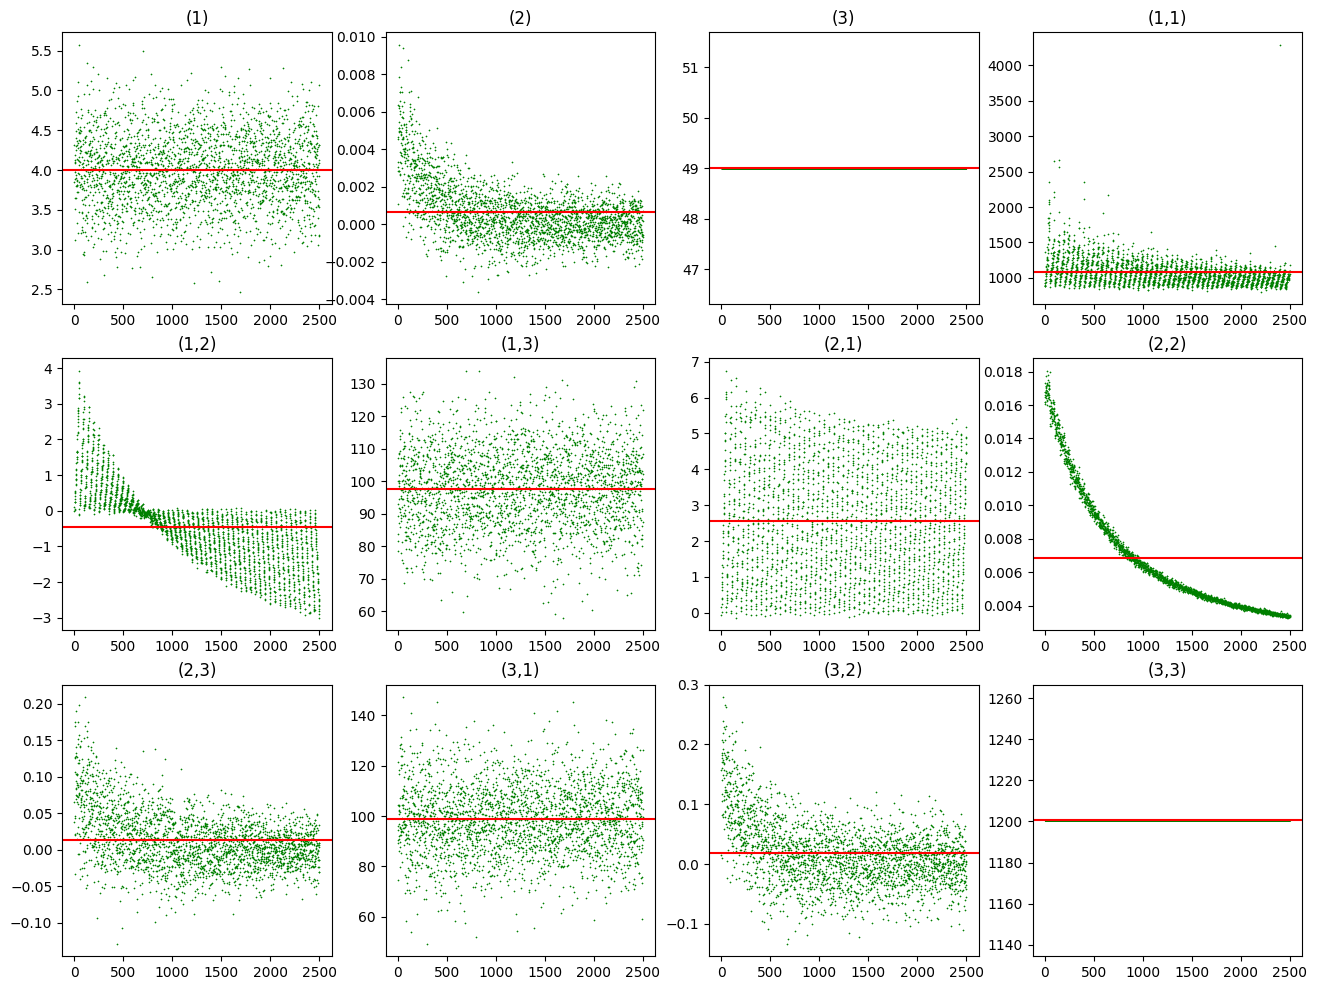

In [70]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(range(1,2501),Exp_signatures_results_kappas_and_rhos.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_kappas_and_rhos.T[i]), color='red')

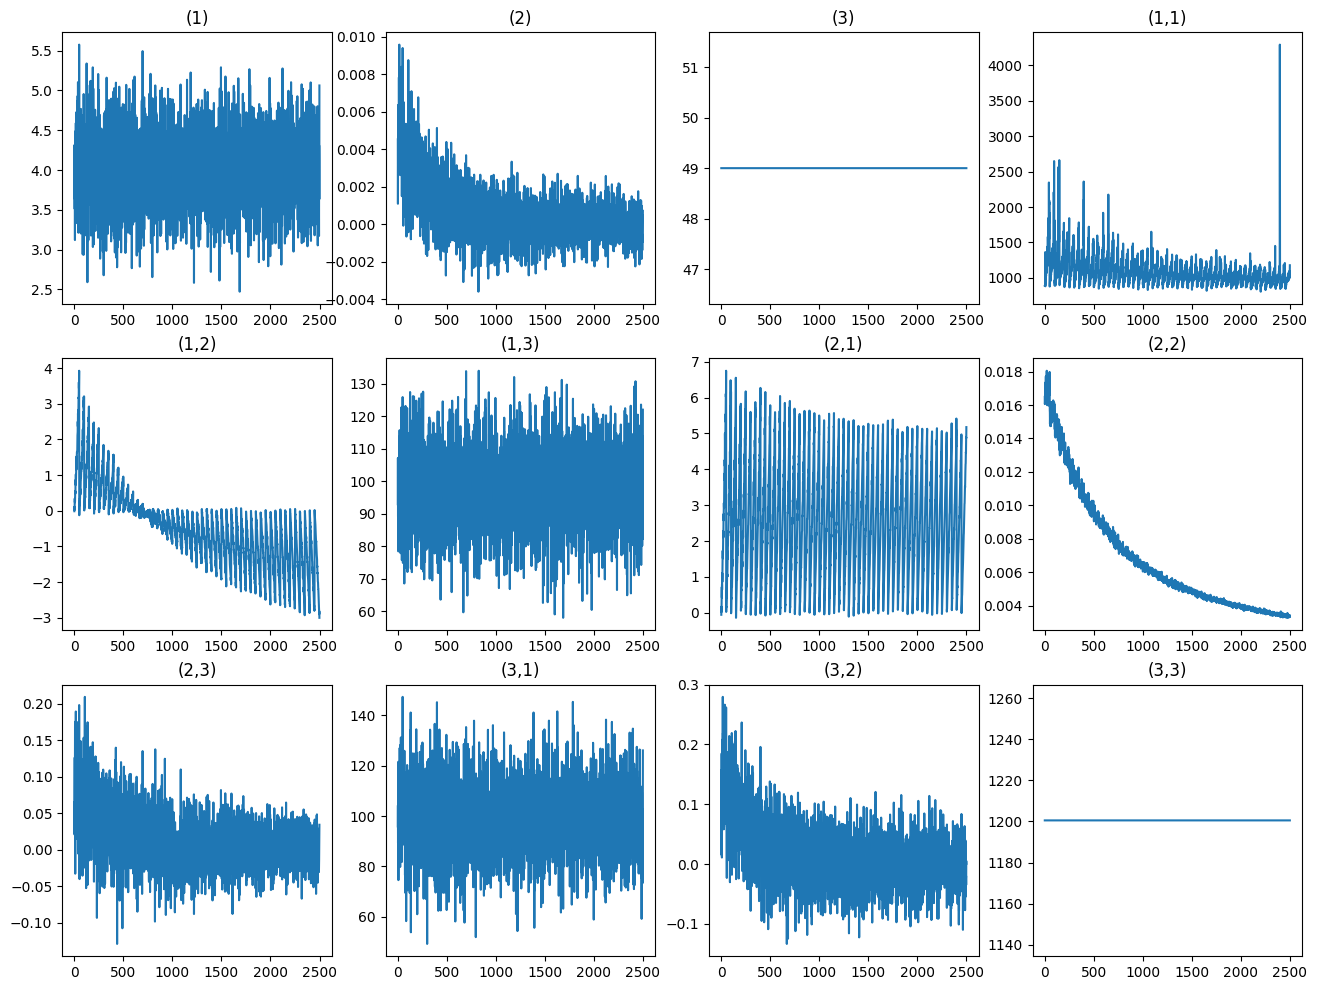

In [71]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(Exp_signatures_results_kappas_and_rhos.T[i])